<a target="_blank" href="https://colab.research.google.com/github/TransformerLensOrg/TransformerLens/blob/main/demos/Main_Demo.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

his notebook is like a special magnifying glass for looking inside a computer program that's really good at writing and understanding words.

Imagine the computer program is like a robot that can read and write stories. This notebook helps us see how the robot thinks and makes decisions when it's writing.

Here are some of the cool things the notebook lets us do:

    Peek inside the robot's brain: We can see all the secret numbers and steps the robot uses when it's trying to understand a sentence or write the next word.
    Change the robot's thoughts: We can temporarily change some of the robot's secret numbers to see how that affects what it writes. It's like giving the robot a little nudge to see what happens!
    Find special thinking parts: We can look for parts of the robot's brain that are really good at specific jobs, like figuring out who gave something to someone in a sentence.
    See how the robot learns: We can look at different versions of the robot from when it was still learning to see how it got so smart at writing.

So, the notebook is all about understanding how these amazing word-writing robots work on the inside!

# Transformer Lens Main Demo Notebook

<b style="color: red">To use this notebook, go to Runtime > Change Runtime Type and select GPU as the hardware accelerator.</b>

This is a reference notebook covering the main features of the [TransformerLens](https://github.com/TransformerLensOrg/TransformerLens) library for mechanistic interpretability. See [Callum McDougall's tutorial](https://transformerlens-intro.streamlit.app/TransformerLens_&_induction_circuits) for a more structured and gentler introduction to the library

**Tips for reading this Colab:**
* You can run all this code for yourself!
* The graphs are interactive!
* Use the table of contents pane in the sidebar to navigate
* Collapse irrelevant sections with the dropdown arrows
* Search the page using the search in the sidebar, not CTRL+F

# Setup
(No need to read)

In [ ]:
import os
DEVELOPMENT_MODE = False
# Detect if we're running in Google Colab,This tries to import a Colab-specific module. If it works, you're in Google Colab.
try:
    import google.colab
    IN_COLAB = True
    print("Running as a Colab notebook")
except:
    IN_COLAB = False

# Install if in Colab
if IN_COLAB:
    %pip install transformer_lens
    %pip install circuitsvis
    # Install a faster Node version
    !curl -fsSL https://deb.nodesource.com/setup_16.x | sudo -E bash -; sudo apt-get install -y nodejs  # noqa

# Hot reload in development mode & not running on the CD
if not IN_COLAB:
    from IPython import get_ipython
    ip = get_ipython()
    if not ip.extension_manager.loaded:
        ip.extension_manager.load('autoreload')
        %autoreload 2

IN_GITHUB = os.getenv("GITHUB_ACTIONS") == "true"


Running as a Colab notebook


                              DEPRECATION WARNING                            

     Node.js 16.x is no longer actively supported!

  You will not receive security or critical stability updates for this version.

  You should migrate to a supported version of Node.js as soon as possible.
  Use the installation script that corresponds to the version of Node.js you
  wish to install. e.g.
  
   * https://deb.nodesource.com/setup_16.x — Node.js 16 "Gallium" (deprecated)
   * https://deb.nodesource.com/setup_18.x — Node.js 18 "Hydrogen" (Maintenance)
   * https://deb.nodesource.com/setup_19.x — Node.js 19 "Nineteen" (deprecated)
   * https://deb.nodesource.com/setup_20.x — Node.js 20 LTS "Iron" (recommended)
   * https://deb.nodesource.com/setup_21.x — Node.js 21 "Iron" (current)
   


  Please see https://github.com/nodejs/Release for details about which
  version may be appropriate for you.

  The NodeSource Node.js distributions repository contains
  informa

| 🔍 **Part**         | 💬 **What It Does**                                |
| ------------------- | -------------------------------------------------- |
| `IN_COLAB`          | Detect if you're in Google Colab                   |
| `pip install` lines | Install needed packages in Colab                   |
| `autoreload`        | Auto-refresh code changes in notebooks (non-Colab) |
| `IN_GITHUB`         | Detect if you're running in GitHub Actions         |


In [ ]:



# Plotly needs a different renderer for VSCode/Notebooks vs Colab argh
import plotly.io as pio
if IN_COLAB or not DEVELOPMENT_MODE:
    pio.renderers.default = "colab"
else:
    pio.renderers.default = "notebook_connected"
print(f"Using renderer: {pio.renderers.default}")

In [ ]:
import circuitsvis as cv
# Testing that the library works
cv.examples.hello("Neel")

✅ Explanation:
circuitsvis is a visualization library often used with transformer models (like GPT).

cv.examples.hello("Neel") runs a demo that outputs something like:

👋 Hello, Neel!

In [ ]:
# Import stuff
import torch
import torch.nn as nn
import einops
from fancy_einsum import einsum
import tqdm.auto as tqdm
import plotly.express as px

from jaxtyping import Float
from functools import partial

| Import              | Purpose                            |
| ------------------- | ---------------------------------- |
| `torch`, `nn`       | Build and train neural networks    |
| `einops`            | Reshape tensors simply             |
| `fancy_einsum`      |readable version of Einstein for summation  math         |
| `tqdm`              | Show progress bars                 |
| `plotly.express`    | Make interactive charts            |
| `jaxtyping.Float`   | Type-checking for tensors          |
| `functools.partial` | Make reusable function "templates" |




In [ ]:
# import transformer_lens
import transformer_lens.utils as utils
from transformer_lens.hook_points import (
    HookPoint,
)  # Hooking utilities
from transformer_lens import HookedTransformer, FactoredMatrix

| Component           | Purpose                                                      |
| ------------------- | ------------------------------------------------------------ |
| `utils`             | Helper functions like logit for data/token processing                   |
| `HookPoint`         | Insert/remove hooks inside the model       and modify activation functiion to see what impact                   |
| `HookedTransformer` | The Transformer model with built-in hook support             |
| `FactoredMatrix`    | Analyze matrices (like weights) in a factored/efficient form |


We turn automatic differentiation off, to save GPU memory, as this notebook focuses on model inference not model training.

In [ ]:
torch.set_grad_enabled(False)

| Code                            | What It Does                                 |
| ------------------------------- | -------------------------------------------- |
| `torch.set_grad_enabled(False)` | Globally disables gradients                  |
| `with torch.no_grad():`         | Disables gradients **only inside the block** |


Plotting helper functions:

In [ ]:
def imshow(tensor, renderer=None, xaxis="", yaxis="", **kwargs):
    px.imshow(utils.to_numpy(tensor), color_continuous_midpoint=0.0, color_continuous_scale="RdBu", labels={"x":xaxis, "y":yaxis}, **kwargs).show(renderer)

def line(tensor, renderer=None, xaxis="", yaxis="", **kwargs):
    px.line(utils.to_numpy(tensor), labels={"x":xaxis, "y":yaxis}, **kwargs).show(renderer)

def scatter(x, y, xaxis="", yaxis="", caxis="", renderer=None, **kwargs):
    x = utils.to_numpy(x)
    y = utils.to_numpy(y)
    px.scatter(y=y, x=x, labels={"x":xaxis, "y":yaxis, "color":caxis}, **kwargs).show(renderer)

| Function  | Use Case                             | Visualization Type |
| --------- | ------------------------------------ | ------------------ |
| `imshow`  | Matrices (e.g. attention, weights)   | Heatmap            |
| `line`    | Trends (e.g. loss func line, logit line, and activation  values over time) | Line plot          |
| `scatter` | Points (e.g. activations, clusters)  | Scatter plot       |


# Introduction

This is a demo notebook for [TransformerLens](https://github.com/TransformerLensOrg/TransformerLens), **a library I ([Neel Nanda](https://neelnanda.io)) wrote for doing [mechanistic interpretability](https://distill.pub/2020/circuits/zoom-in/) of GPT-2 Style language models.** The goal of mechanistic interpretability is to take a trained model and reverse engineer the algorithms the model learned during training from its weights. It is a fact about the world today that we have computer programs that can essentially speak English at a human level (GPT-3, PaLM, etc), yet we have no idea how they work nor how to write one ourselves. This offends me greatly, and I would like to solve this! Mechanistic interpretability is a very young and small field, and there are a *lot* of open problems - if you would like to help, please try working on one! **If you want to skill up, check out [my guide to getting started](https://neelnanda.io/getting-started), and if you want to jump into an open problem check out my sequence [200 Concrete Open Problems in Mechanistic Interpretability](https://neelnanda.io/concrete-open-problems).**

I wrote this library because after I left the Anthropic interpretability team and started doing independent research, I got extremely frustrated by the state of open source tooling. There's a lot of excellent infrastructure like HuggingFace and DeepSpeed to *use* or *train* models, but very little to dig into their internals and reverse engineer how they work. **This library tries to solve that**, and to make it easy to get into the field even if you don't work at an industry org with real infrastructure! The core features were heavily inspired by [Anthropic's excellent Garcon tool](https://transformer-circuits.pub/2021/garcon/index.html). Credit to Nelson Elhage and Chris Olah for building Garcon and showing me the value of good infrastructure for accelerating exploratory research!

The core design principle I've followed is to enable exploratory analysis - one of the most fun parts of mechanistic interpretability compared to normal ML is the extremely short feedback loops! The point of this library is to keep the gap between having an experiment idea and seeing the results as small as possible, to make it easy for **research to feel like play** and to enter a flow state. This notebook demonstrates how the library works and how to use it, but if you want to see how well it works for exploratory research, check out [my notebook analysing Indirect Objection Identification](https://neelnanda.io/exploratory-analysis-demo) or [my recording of myself doing research](https://www.youtube.com/watch?v=yo4QvDn-vsU)!

Simplified text
Sure! Here's a simplified version of the main points from the text — **explained like you're a curious child**:

---

### 🧠 What Is This About?

This is a notebook (a kind of special computer document) made by a person named **Neel Nanda**. He built a tool called **TransformerLens** to help understand how smart computer programs (like ChatGPT or GPT-3) actually **think**.

---

### 🤔 The Big Problem

Smart models like GPT-3 can talk like humans...
But no one really knows **how** they do it.
It’s like having a robot that can do magic tricks, but we don’t know the secret behind them.

Neel finds this frustrating and wants to **figure out the secrets inside** these models.
That’s called **mechanistic interpretability** — trying to "look inside the robot’s brain" and understand how it works.

---

### 🛠️ Why He Built TransformerLens

Neel was doing research on his own and realized:

> “There are lots of tools to **use** or **train** AI models... but not many to **understand** them.”

So he made **TransformerLens** to:

* Let researchers easily explore what's happening inside language models
* Help people learn and join this field
* Make experiments faster and more fun

---

### ⚡ Cool Design Idea

The best part? This tool helps you test ideas **quickly** — like doing a science experiment where you see the results **right away**.
That makes research feel like **playtime**!

---

### 👋 Final Message

Neel is saying:

> "If you're curious and want to help understand how these smart AIs work — **join us!** This is a brand-new field with tons of exciting puzzles to solve."

---

Let me know if you'd like this as a cartoon or visual explainer too!


## Loading and Running Models

TransformerLens comes loaded with >40 open source GPT-style models. You can load any of them in with `HookedTransformer.from_pretrained(MODEL_NAME)`. For this demo notebook we'll look at GPT-2 Small, an 80M parameter model, see the Available Models section for info on the rest.

In [ ]:
device = utils.get_device()

In [ ]:
# NBVAL_IGNORE_OUTPUT
model = HookedTransformer.from_pretrained("gpt2-small", device=device)

"Hey toolbox, give me the mini version of the talking robot brain, and set it up to run on my computer's fast engine."

HookedTransformer: This is a special version transforemer(builtin hook ) made for exploring how  GPT model  thinks. Track attention, activations, and other hidden parts

“Hook into” layers so you can analyze or change what the model does mid-thought



To try the model out, let's find the loss on this text! Models can be run on a single string or a tensor of tokens (shape: [batch, position], all integers), and the possible return types are:
* "logits" (shape [batch, position, d_vocab], floats),
* "loss" (the cross-entropy loss when predicting the next token),
* "both" (a tuple of (logits, loss))
* None (run the model, but don't calculate the logits - this is faster when we only want to use intermediate activations)

Simple understand
🧪 What are we trying to do?
We want to test the model by giving it some text and seeing how well it understands or predicts it.
We do this by checking its loss — a number that tells us how wrong the model is when trying to guess the next word or token.

🧠 How do we give the model input?
You can give the model:

A string (like "Hello, how are you?")

Or a tensor of tokens (which is just a fancy list of numbers that represent words or pieces of words)

Example shape for tokens:
[batch, position]
Means: multiple sentences (batch), and the number of words or tokens in each (position)

| What You Ask For | What It Means                                                                  |
| ---------------- | ------------------------------------------------------------------------------ |
| `"logits"`       | The model's raw guesses for the next word/token at each step                   |
| `"loss"`         | A number showing **how wrong** the model was in predicting the next word       |
| `"both"`         | A pair: the raw guesses **and** the loss number                                |
| `None`           | Don’t return guesses — just run the model so we can look at its inner thinking |


In [ ]:
model_description_text = """## Loading Models

HookedTransformer comes loaded with >40 open source GPT-style models. You can load any of them in with `HookedTransformer.from_pretrained(MODEL_NAME)`. See my explainer for documentation of all supported models, and this table for hyper-parameters and the name used to load them. Each model is loaded into the consistent HookedTransformer architecture, designed to be clean, consistent and interpretability-friendly.

For this demo notebook we'll look at GPT-2 Small, an 80M parameter model. To try the model the model out, let's find the loss on this paragraph!"""
loss = model(model_description_text, return_type="loss")
print("Model loss:", loss)

You're giving the model a paragraph and asking:

“Hey smart robot brain, how well can you guess the next word in this text?”

And the model replies with a number called "loss" that tells us how well (or badly) it did.

🧸 Analogy:
It’s like giving a kid a sentence with some blanks and seeing how many they get right.

"The cat sat on the ___."
If they say “mat”, great! Low loss.
If they say “refrigerator”, hmm... high loss!



 What does a lower loss mean?
✅ Small number (like 1.2): The model was pretty good at predicting.

❌ Big number (like 5.0): The model was way off and didn’t guess well.

## Caching all Activations

The first basic operation when doing mechanistic interpretability is to break open the black box of the model and look at all of the internal activations of a model. This can be done with `logits, cache = model.run_with_cache(tokens)`. Let's try this out on the first line of the abstract of the GPT-2 paper.

<details><summary>On `remove_batch_dim`</summary>

Every activation inside the model begins with a batch dimension. Here, because we only entered a single batch dimension, that dimension is always length 1 and kinda annoying, so passing in the `remove_batch_dim=True` keyword removes it. `gpt2_cache_no_batch_dim = gpt2_cache.remove_batch_dim()` would have achieved the same effect.
</details?>

Simple explanation:
When we ask the model to think about some words, it does a lot of small calculations inside — these are called activations.
Caching activations means saving all these little steps so we can look at them later, like recording what’s happening inside the model’s brain.

In [ ]:
gpt2_text = "Natural language processing tasks, such as question answering, machine translation, reading comprehension, and summarization, are typically approached with supervised learning on taskspecific datasets."
gpt2_tokens = model.to_tokens(gpt2_text)
print(gpt2_tokens.device)
gpt2_logits, gpt2_cache = model.run_with_cache(gpt2_tokens, remove_batch_dim=True)

Interpretation the code:

You give the model a sentence:
"Natural language processing tasks, such as question answering, machine translation, reading comprehension, and summarization, are typically approached with supervised learning on task-specific datasets."

You turn the sentence into tokens with:

gpt2_tokens = model.to_tokens(gpt2_text)
This means the model changes the words into numbers it can understand.

You check where those tokens are stored (like on your computer’s CPU or GPU):


print(gpt2_tokens.device)
It tells you if the tokens are on the right place for fast calculations.

You run the model with caching to get the guesses (logits) and save all the internal “thoughts” (activations) in gpt2_cache:


gpt2_logits, gpt2_cache = model.run_with_cache(gpt2_tokens, remove_batch_dim=True)
You also remove the extra batch layer for easier analysis (remove_batch_dim=True).

Let's visualize the attention pattern of all the heads in layer 0, using [Alan Cooney's CircuitsVis library](https://github.com/alan-cooney/CircuitsVis) (based on [Anthropic's PySvelte library](https://github.com/anthropics/PySvelte)).

We look this the attention pattern in `gpt2_cache`, an `ActivationCache` object, by entering in the name of the activation, followed by the layer index (here, the activation is called "attn" and the layer index is 0). This has shape [head_index, destination_position, source_position], and we use the `model.to_str_tokens` method to convert the text to a list of tokens as strings, since there is an attention weight between each pair of tokens.

This visualization is interactive! Try hovering over a token or head, and click to lock. The grid on the top left and for each head is the attention pattern as a destination position by source position grid. It's lower triangular because GPT-2 has **causal attention**, attention can only look backwards, so information can only move forwards in the network.

See the ActivationCache section for more on what `gpt2_cache` can do.

In [ ]:
print(type(gpt2_cache))
attention_pattern = gpt2_cache["pattern", 0, "attn"]
print(attention_pattern.shape)
gpt2_str_tokens = model.to_str_tokens(gpt2_text)

👀 What are we doing?
We’re going to look inside the model’s “attention” — how the model decides which words to focus on when reading a sentence.

🧠 What is attention?
Imagine when you read a story, sometimes you pay more attention to certain words because they help you understand the meaning better. The model does the same thing! It looks at some words more closely than others.

🖼️ How do we see this?
The model has layers, like floors in a building.

Each layer has many heads, like little eyes looking at different parts of the sentence.

We’ll look at layer 0 (the first floor), at all the heads (all the eyes).

🔍 What is gpt2_cache?
It’s like a big notebook where the model wrote down all the attention information.

We find the attention data by asking for "attn" at layer 0.

📏 What does the attention pattern look like?
It’s a grid showing how much attention each word gives to every other word.

It’s a lower triangular grid because the model can only pay attention to words that came before in the sentence — it can’t peek into the future!

🎮 Cool part — it’s interactive!
You can move your mouse over tokens or heads to see what the model is focusing on, and click to freeze your view.



1. print(type(gpt2_cache))
This line asks: What kind of thing is gpt2_cache?

It will print the type (or class) of the object called gpt2_cache.

This helps you understand what data or information you’re working with.

2. attention_pattern = gpt2_cache["pattern", 0, "attn"]
This line gets the attention pattern from the cache.

"pattern" means we want the attention weights (how much one word looks at another).

0 means we want the data from layer 0 (the first layer in the model).

"attn" tells it we want the attention activations.

So, attention_pattern now holds a grid showing which words pay attention to which other words in the first layer.

3. print(attention_pattern.shape)
This prints the shape (or size) of the attention_pattern data.

The shape usually looks like [number_of_heads, destination_positions, source_positions].

This tells you how many attention heads there are, and how many tokens (words) the model is looking at.

4. gpt2_str_tokens = model.to_str_tokens(gpt2_text)
This line turns the original text (gpt2_text) into a list of tokens as strings.

Tokens are like little pieces of words or whole words that the model understands.

This helps when you want to match the attention pattern to actual words you can read.

Summary:
You check what gpt2_cache is.

You get the attention pattern from layer 0.

You check the size of that attention pattern.

You get the list of tokens (words) for the original sentence.

How the attention happen
🔍 1. What's Being Visualized?

This shows attention patterns in the first Transformer layer (Layer 0) of GPT-2. Each pattern shows where a specific attention head is focusing—that is, which previous tokens each token "looks at" to make its prediction.

    Think of it like:
    Each token is asking, "Who should I listen to?"
    Each head gives a different answer!

🧠 2. What's an Attention Head?

A Transformer layer usually has multiple heads (12 here). Each head learns to focus on different relationships in the sentence.
Head #	Might be focusing on...
Head 0	Nearby words (local attention)
Head 3	Syntactic roles (subject, verb)
Head 5	Previous sentence start
Head 8	Punctuation or sentence boundaries
Head 11	Long-range dependencies
🖼️ 3. Interpreting the Attention Maps

In [ ]:
print("Layer 0 Head Attention Patterns:")
cv.attention.attention_patterns(tokens=gpt2_str_tokens, attention=attention_pattern)

3. Interpreting the Attention Maps

Each small square is a heatmap (matrix), where:

    Rows = destination tokens (which word is paying attention)

    Columns = source tokens (which word it's attending to)

    Color = strength of attention (brighter = more attention)

    🔁 The diagonal line often means "pay attention to the previous word" (common early on in training).

    🧬 Off-diagonal patterns may show dependency structures, like one token attending to its subject or object.

🧠 Think of a Transformer Layer Like a Team
Imagine:

A Transformer layer is like a big smart team, and each attention head is a specialist in the team.

    Each attention head looks at the input tokens and says:

        “Based on what I specialize in, I think token 5 should pay attention to token 2.”

    Each head does this in parallel.

    Then their outputs are combined and passed into a feedforward neural network (this part does have neurons).

🔍 Inside a Transformer Layer

Each layer of a Transformer (like GPT-2) has two main parts:
Part	What's inside?	Purpose
1. Multi-head Attention	12 attention heads (each with matrices Q, K, V)	Lets the model “look around” at other tokens
2. Feedforward Network	Thousands of regular neurons (MLP)	Learns features and transformations

So if you see 12 attention heads, that just means:

    There are 12 separate attention pathways, each learning different patterns.

    Each head has its own parameters (weights), but they are not neurons.

📊 Example: GPT-2 Small

In GPT-2 small (117M parameters):

    Each layer has 12 heads

    Each layer also has a feedforward MLP with 3072 neurons

    The model has 12 layers total

So attention heads are only one part of what’s going on. Most of the parameters and compute are in the feedforward MLP, not the attention heads!
🧠 Analogy: Classroom with Advisors

    Imagine you're in a classroom.

    You ask for help on a question.

    You have 12 advisors (attention heads), each specializing in something different (grammar, logic, memory).

    Each advisor gives you a suggestion.

    You average their help and then pass that into your brain (MLP) to decide the final answer.

✅ Summary
Concept	Description
Attention Head	One of many “focusing” mechanisms in each layer that decides which other tokens are important
Neuron	A unit in the MLP part that applies weights, biases, and non-linear activation
Layer 0	The first Transformer layer, which contains both attention heads and MLP neurons

🧪 Curious Next Steps for You:

    Try changing the input text and see how attention patterns change.

    Freeze on one token (like "translation") and explore how all heads treat it.

    Look at later layers (e.g., Layer 10) and compare how attention becomes more semantic and structured.

In this case, we only wanted the layer 0 attention patterns, but we are storing the internal activations from all layer  locations in the model. It's convenient to have access to all activations, but this can be prohibitively expensive for memory use with larger models, batch sizes, or sequence lengths. In addition, we don't need to do the full forward pass through the model to collect layer 0 attention patterns. The following cell will collect only the layer 0 attention patterns and stop the forward pass at layer 1, requiring far less memory and compute.

In [ ]:
attn_hook_name = "blocks.0.attn.hook_pattern"
attn_layer = 0
_, gpt2_attn_cache = model.run_with_cache(gpt2_tokens, remove_batch_dim=True, stop_at_layer=attn_layer + 1, names_filter=[attn_hook_name])
gpt2_attn = gpt2_attn_cache[attn_hook_name]
assert torch.equal(gpt2_attn, attention_pattern)

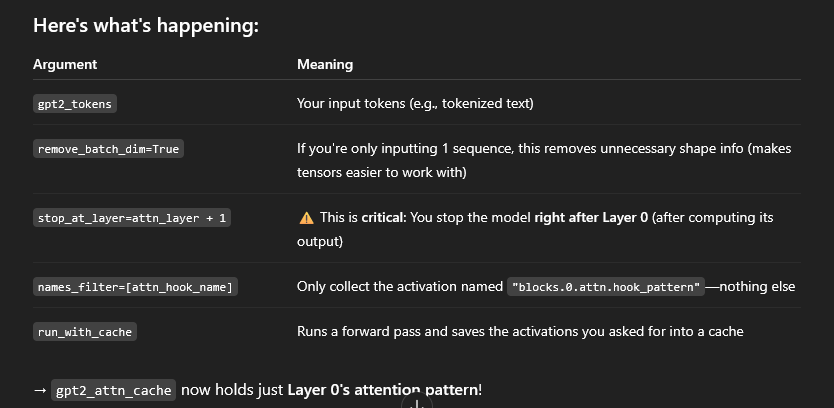

🧠 Summary:
Goal	How It's Done
Collect Layer 0 attention patterns only	Use stop_at_layer=1 and names_filter=["blocks.0.attn.hook_pattern"]
Avoid storing all layers' activations	✅ Much faster and lower memory
Compare to full run	Use torch.equal() to confirm equivalence

🧠 Why Do We Use Softmax in the Output Layer of Standard Neural Nets?

In a classification neural net (e.g., image classifier), the last layer produces logits (raw scores), and softmax turns them into probabilities across classes.

    That’s where we make the final decision (e.g., cat vs dog).

    We train it with cross-entropy loss, which expects probabilities.

✅ So softmax at the output makes sense for class predictions.
🔁 But in a Transformer, We Use Softmax in the Attention Layer — Why?
Key insight:

    We don’t use softmax to make a final prediction,
    We use it to decide how much attention one token pays to others.

Let me explain visually:
🔗 Attention Mechanism Recap

Each token wants to ask:

    "Whom should I listen to from the other tokens?"

It computes attention scores between itself and every other token (dot products of query and key vectors).
These scores could be any real number, even negative.

We apply softmax to these scores to turn them into attention weights:
Example:
Token Pair	Raw Score	Softmax Weight
"The" attends to "cat"	2.0	0.73
"The" attends to "sat"	1.0	0.27

Now the model will:

    Take 73% of the info from "cat"

    Take 27% of the info from "sat"

This is how attention works.

    🧠 Softmax makes attention selective and interpretable.

✅ Why Softmax in Layer 0 (and all attention layers)?

Even in Layer 0, the model must decide where to focus in the input sentence.

Without softmax:

    Attention scores could be unbounded (bad for training)

    No normalization = no probabilistic interpretation

    Could lead to unstable or arbitrary token mixing

With softmax:

    Token attends more strongly to relevant others

    Prevents exploding weights or "fuzzy" mixing

    Enables multiple heads to learn different focus patterns

📌 Summary Table
Where is Softmax Used?	Why Use It?
Output layer of classifier	Convert logits to class probabilities
Attention mechanism (all layers, incl. Layer 0)	Turn raw similarity scores into attention weights — to focus!
🤓 Bonus: Could We Use Other Functions Instead of Softmax?

Yes! Researchers have explored:

    Sparsemax (outputs sparse weights)

    Entmax (generalizes softmax to be smoother or sharper)

    Linear attention (avoids softmax for speed)

But softmax is still the most common because:

    It’s smooth, differentiable

    Easy to train

    Works well empirically

🎓 Final Thought

    Softmax in attention is not for prediction, it's for deciding where to look.
    It turns attention scores into a focused distribution over other tokens.

## Hooks: Intervening on Activations

One of the great things about interpreting neural networks is that we have *full control* over our system. From a computational perspective, we know exactly what operations are going on inside (even if we don't know what they mean!). And we can make precise, surgical edits and see how the model's behaviour and other internals change. This is an extremely powerful tool, because it can let us eg set up careful counterfactuals and causal intervention to easily understand model behaviour.

Accordingly, being able to do this is a pretty core operation, and this is one of the main things TransformerLens supports! The key feature here is **hook points**. Every activation inside the transformer is surrounded by a hook point, which allows us to edit or intervene on it.

We do this by adding a **hook function** to that activation. The hook function maps `current_activation_value, hook_point` to `new_activation_value`. As the model is run, it computes that activation as normal, and then the hook function is applied to compute a replacement, and that is substituted in for the activation. The hook function can be an arbitrary Python function, so long as it returns a tensor of the correct shape.

<details><summary>Relationship to PyTorch hooks</summary>

[PyTorch hooks](https://blog.paperspace.com/pytorch-hooks-gradient-clipping-debugging/) are a great and underrated, yet incredibly janky, feature. They can act on a layer, and edit the input or output of that layer, or the gradient when applying autodiff. The key difference is that **Hook points** act on *activations* not layers. This means that you can intervene within a layer on each activation, and don't need to care about the precise layer structure of the transformer. And it's immediately clear exactly how the hook's effect is applied. This adjustment was shamelessly inspired by [Garcon's use of ProbePoints](https://transformer-circuits.pub/2021/garcon/index.html).

They also come with a range of other quality of life improvements, like the model having a `model.reset_hooks()` method to remove all hooks, or helper methods to temporarily add hooks for a single forward pass - it is *incredibly* easy to shoot yourself in the foot with standard PyTorch hooks!
</details>

Neural networks = robot brains we can control.

TransformerLens = a microscope for those brains.

Hook points = trapdoors we can use to see or change what the brain is thinking.

Hook functions = little rules that decide what to change.

PyTorch hooks = similar, but messier and less precise.

As a basic example, let's [ablate](https://dynalist.io/d/n2ZWtnoYHrU1s4vnFSAQ519J#z=fh-HJyz1CgUVrXuoiban6bYx) head 7 in layer 0 on the text above.

We define a `head_ablation_hook` function. This takes the value tensor for attention layer 0, and sets the component with `head_index==7` to zero and returns it (Note - we return by convention, but since we're editing the activation in-place, we don't strictly *need* to).

We then use the `run_with_hooks` helper function to run the model and *temporarily* add in the hook for just this run. We enter in the hook as a tuple of the activation name (also the hook point name - found with `utils.get_act_name`) and the hook function.

Simple explanation aboutHead_abalation hook function
🧠 What's Happening Here?
We’re doing something really specific and cool:
We’re going to "ablate" (turn off) one tiny thinking part of the robot brain: head 7 in layer 0.

Imagine the brain is made up of layers of mini brains called attention heads. Each head looks at the words you give it and tries to figure out what's important.

So in this example, we say:

"Let’s turn off head number 7 in the first layer and see what changes in the robot’s thinking!"

⚙️ How Do We Do That?
We write a hook function called head_ablation_hook.

This is like writing a rule that says:

“Hey! If you're head number 7, stop thinking. Just be zero — like you’re asleep.”

In code, this means:
We look at a big list of what all the heads are thinking (this is called a tensor, like a magic spreadsheet), and we set the row for head 7 to zero.

We run the model using run_with_hooks.

That’s like running the robot brain with your hook active — but just this one time.

We say:

“Hey robot, think about the sentence we gave you. But this time, head 7 in layer 0 isn’t allowed to help. Let’s see what you say.”

🛠️ Behind the Scenes
To tell the model exactly where to put the hook, we give it two things:

A hook point name — this is just the label that says:

“Go to layer 0, in the attention part, before outputting anything.”

We find that name using something like utils.get_act_name.

The hook function — that’s our custom rule that zeros out head 7.

🧪 Why is This Cool?
It’s like doing science on a brain! You can:

Turn off one part and see how it behaves differently.

Learn which parts matter for certain thoughts.

Find out which heads do grammar, which do names, or which love talking about cats 😺



In [ ]:
layer_to_ablate = 0
head_index_to_ablate = 8

# We define a head ablation hook
# The type annotations are NOT necessary, they're just a useful guide to the reader
#
def head_ablation_hook(
    value: Float[torch.Tensor, "batch pos head_index d_head"],
    hook: HookPoint
) -> Float[torch.Tensor, "batch pos head_index d_head"]:
    print(f"Shape of the value tensor: {value.shape}")
    value[:, :, head_index_to_ablate, :] = 0.
    return value

original_loss = model(gpt2_tokens, return_type="loss")
ablated_loss = model.run_with_hooks(
    gpt2_tokens,
    return_type="loss",
    fwd_hooks=[(
        utils.get_act_name("v", layer_to_ablate),
        head_ablation_hook
        )]
    )
print(f"Original Loss: {original_loss.item():.3f}")
print(f"Ablated Loss: {ablated_loss.item():.3f}")

🤖 What Is This Code Doing?
You’re giving the robot (the model) some words, then:

Measuring how well it understands them. (That’s the original_loss)

Turning off one tiny part of its brain. (Head 8 in Layer 0)

Measuring again. (That’s the ablated_loss)

Comparing the two to see if turning that part off made the robot worse at understanding.

🧠 What’s an Attention Head?
Remember: each layer in the robot brain has several little mini-brains called attention heads. Each one looks at the sentence and pays attention to different things — maybe grammar, important words, or sentence structure.

This code turns off head 8 in layer 0 — we’re basically telling that mini-brain:

“Shh! You’re not allowed to think this time.”

🎯 Finding the Right Spot
python
Copy
Edit
utils.get_act_name("v", layer_to_ablate)
This finds the exact place in the robot brain where the attention heads produce their output (the "V" part in "QKV" — a key part of attention). You’re saying:

“Hook into the ‘value’ output of layer 0.”

🧪 Running the Experiment
python
Copy
Edit
original_loss = model(gpt2_tokens, return_type="loss")
First, you run the model normally and check the loss — which is a score for how wrong it was (lower is better).

python
Copy
Edit
ablated_loss = model.run_with_hooks(
    gpt2_tokens,
    return_type="loss",
    fwd_hooks=[(hook_point_name, head_ablation_hook)]
)
Then you run it again, but this time with your hook in place — head 8 is now silent.



Important nootes about HOOK function use :
**bold text**
Hooks change what the model does — like spies in the brain.

run_with_hooks adds them temporarily.

But if there's an error, they might stay stuck.

Use model.reset_hooks() to clean up if that happens.

Use add_perma_hook() only if you want them to stay on purpose.



### Activation Patching on the Indirect Object Identification Task

For a somewhat more involved example, let's use hooks to apply **[activation patching](https://dynalist.io/d/n2ZWtnoYHrU1s4vnFSAQ519J#z=qeWBvs-R-taFfcCq-S_hgMqx)** on the **[Indirect Object Identification](https://dynalist.io/d/n2ZWtnoYHrU1s4vnFSAQ519J#z=iWsV3s5Kdd2ca3zNgXr5UPHa)** (IOI) task.

The IOI task is the task of identifying that a sentence like "After John and Mary went to the store, Mary gave a bottle of milk to" continues with " John" rather than " Mary" (ie, finding the indirect object), and Redwood Research have [an excellent paper studying the underlying circuit in GPT-2 Small](https://arxiv.org/abs/2211.00593).

**[Activation patching](https://dynalist.io/d/n2ZWtnoYHrU1s4vnFSAQ519J#z=qeWBvs-R-taFfcCq-S_hgMqx)** is a technique from [Kevin Meng and David Bau's excellent ROME paper](https://rome.baulab.info/). The goal is to identify which model activations are important for completing a task. We do this by setting up a **clean prompt** and a **corrupted prompt** and a **metric** for performance on the task. We then pick a specific model activation, run the model on the corrupted prompt, but then *intervene* on that activation and patch in its value when run on the clean prompt. We then apply the metric, and see how much this patch has recovered the clean performance.
(See [a more detailed demonstration of activation patching here](https://colab.research.google.com/github/TransformerLensOrg/TransformerLens/blob/main/demos/Exploratory_Analysis_Demo.ipynb))

Here, our clean prompt is "After John and Mary went to the store, **Mary** gave a bottle of milk to", our corrupted prompt is "After John and Mary went to the store, **John** gave a bottle of milk to", and our metric is the difference between the correct logit ( John) and the incorrect logit ( Mary) on the final token.

We see that the logit difference is significantly positive on the clean prompt, and significantly negative on the corrupted prompt, showing that the model is capable of doing the task!

Awesome! You're now stepping into activation patching, one of the coolest and most powerful tools in transformer interpretability — like brain surgery with a scalpel and microscope!

🧪 What Is the IOI Task?
Let’s start with the task first.

You’re asking the model to fill in the blank:

“After John and Mary went to the store, Mary gave a bottle of milk to ___”

Who should go in the blank?
✅ John, because he’s receiving the milk.
❌ Not Mary, because she’s the one giving it.

That’s called Indirect Object Identification (IOI) — figuring out who is getting something.

🧠 What’s Activation Patching?
Imagine running two different versions of the same story through your robot brain:

Clean Prompt: the story makes sense

"...Mary gave...to __" → should continue with John

Corrupted Prompt: a confusing version

"...John gave...to __" → makes the model more likely to wrongly pick Mary

Now here’s the magic:

We let the model read the corrupted prompt, but at one specific moment in the brain’s process, we say:

“Wait! At this exact spot, copy the thought it had from the clean story instead.”

That’s activation patching — swapping out just one piece of the corrupted brain state with the clean one, and seeing if that makes the model act more correctly.

It’s like saying:

“If I just fix this one memory, does the model remember who got the milk?”

🔍 What’s the Metric?
We want to measure how well the model is doing the task. So we look at the logits — the model’s raw guesses — and compare:

python
Copy
Edit
logit_diff = logit["John"] - logit["Mary"]
✅ On the clean prompt, this number should be positive → John is more likely.

❌ On the corrupted prompt, this number is negative → Mary is more likely.

If the patched version goes back to being positive, then the thing we patched was important!

🧪 The Recipe for Activation Patching
Let’s summarize the steps:

Set up your prompts:

Clean: “Mary gave a bottle of milk to ___”

Corrupted: “John gave a bottle of milk to ___”

Run both through the model.

Save the activation values from the clean run.

Use a hook to replace a specific activation in the corrupted run with the clean one.

Measure the effect.

If the model’s logit difference moves toward the clean version, then that activation matters!



In [ ]:
clean_prompt = "After John and Mary went to the store, Mary gave a bottle of milk to"
corrupted_prompt = "After John and Mary went to the store, John gave a bottle of milk to"

clean_tokens = model.to_tokens(clean_prompt)
corrupted_tokens = model.to_tokens(corrupted_prompt)

def logits_to_logit_diff(logits, correct_answer=" John", incorrect_answer=" Mary"):
    # model.to_single_token maps a string value of a single token to the token index for that token
    # If the string is not a single token, it raises an error.
    correct_index = model.to_single_token(correct_answer)
    incorrect_index = model.to_single_token(incorrect_answer)
    return logits[0, -1, correct_index] - logits[0, -1, incorrect_index]

# We run on the clean prompt with the cache so we store activations to patch in later.
clean_logits, clean_cache = model.run_with_cache(clean_tokens)
clean_logit_diff = logits_to_logit_diff(clean_logits)
print(f"Clean logit difference: {clean_logit_diff.item():.3f}")

# We don't need to cache on the corrupted prompt.
corrupted_logits = model(corrupted_tokens)
corrupted_logit_diff = logits_to_logit_diff(corrupted_logits)
print(f"Corrupted logit difference: {corrupted_logit_diff.item():.3f}")

What code do:
Perfect! You're now doing a **real activation patching setup**, and you've just completed the **first half** of the experiment: collecting the clean and corrupted outputs.

Let’s walk through what this code is doing and why it's so cool — step by step, in kid-curious style:

---

## 🧼 Step 1: Define the Prompts

```python
clean_prompt = "After John and Mary went to the store, Mary gave a bottle of milk to"
corrupted_prompt = "After John and Mary went to the store, John gave a bottle of milk to"
```

You're telling **two slightly different stories** to the model:

* ✅ In the clean one, **Mary** gives milk → model should guess **John** is the recipient.
* ❌ In the corrupted one, **John** gives milk → model might wrongly guess **Mary**.

You're setting up a situation where **only one word changes**, but it **confuses** the model.

---

## 🧠 Step 2: Turn Prompts into Tokens

```python
clean_tokens = model.to_tokens(clean_prompt)
corrupted_tokens = model.to_tokens(corrupted_prompt)
```

The model doesn’t understand plain words. This step turns the prompts into **token numbers** — like turning words into puzzle pieces it can work with.

---

## 📏 Step 3: Define the Metric (Logit Difference)

```python
def logits_to_logit_diff(logits, correct_answer=" John", incorrect_answer=" Mary"):
    correct_index = model.to_single_token(correct_answer)
    incorrect_index = model.to_single_token(incorrect_answer)
    return logits[0, -1, correct_index] - logits[0, -1, incorrect_index]
```

This is the **score system**.

* The model makes a guess about **what the next word should be** (called a *logit* — bigger means "more likely").
* You compare:

  * How likely is **John**?
  * How likely is **Mary**?
* A **positive score** means it's doing the task well.
* A **negative score** means it's getting confused.

---

## 🧠 Step 4: Run the Clean Prompt & Cache Activations

```python
clean_logits, clean_cache = model.run_with_cache(clean_tokens)
```

Here’s the big move!

You're running the model on the clean story and saying:

> “Save every thought the model had at every layer — so I can borrow one later.”

You store that in `clean_cache`.

---

## ❌ Step 5: Run the Corrupted Prompt (No Cache Needed)

```python
corrupted_logits = model(corrupted_tokens)
```

Now you run the **wrong version**, without saving anything — just seeing how badly it messes up.

---

## 📊 Step 6: Measure the Differences

```python
print(f"Clean logit difference: {clean_logit_diff.item():.3f}")
print(f"Corrupted logit difference: {corrupted_logit_diff.item():.3f}")
```

You print the score for both versions.

* ✅ Clean: Should be **positive** → “John” more likely than “Mary”.
* ❌ Corrupted: Should be **negative** → the model wrongly favors “Mary”.

---







We now setup the hook function to do activation patching. Here, we'll patch in the [residual stream](https://dynalist.io/d/n2ZWtnoYHrU1s4vnFSAQ519J#z=DHp9vZ0h9lA9OCrzG2Y3rrzH) at the start of a specific layer and at a specific position. This will let us see how much the model is using the residual stream at that layer and position to represent the key information for the task.

We want to iterate over all layers and positions, so we write the hook to take in an position parameter. Hook functions must have the input signature (activation, hook), but we can use `functools.partial` to set the position parameter before passing it to `run_with_hooks`

**surgical part of activation patching**:
Awesome — now you’re moving into the surgical part of activation patching: using a hook to replace part of the model's memory (the residual stream) during a run!

Let’s break this down so it’s crystal clear, even for someone new but curious.

🧠 What Is the Residual Stream?
Think of the residual stream like the model’s notebook — every time it thinks something, it writes it down. Every layer reads from and adds to this notebook.

By patching the residual stream, you’re saying:

“At this layer and this position (word), replace what the corrupted prompt wrote in the notebook with what the clean prompt wrote instead.”

If doing that fixes the model’s answer, it means that specific note was really important!



In [ ]:
# We define a residual stream patching hook
# We choose to act on the residual stream at the start of the layer, so we call it resid_pre
# The type annotations are a guide to the reader and are not necessary
def residual_stream_patching_hook(
    resid_pre: Float[torch.Tensor, "batch pos d_model"],
    hook: HookPoint,
    position: int
) -> Float[torch.Tensor, "batch pos d_model"]:
    # Each HookPoint has a name attribute giving the name of the hook.
    clean_resid_pre = clean_cache[hook.name]
    resid_pre[:, position, :] = clean_resid_pre[:, position, :]
    return resid_pre

# We make a tensor to store the results for each patching run. We put it on the model's device to avoid needing to move things between the GPU and CPU, which can be slow.
num_positions = len(clean_tokens[0])
ioi_patching_result = torch.zeros((model.cfg.n_layers, num_positions), device=model.cfg.device)

for layer in tqdm.tqdm(range(model.cfg.n_layers)):
    for position in range(num_positions):
        # Use functools.partial to create a temporary hook function with the position fixed
        temp_hook_fn = partial(residual_stream_patching_hook, position=position)
        # Run the model with the patching hook
        patched_logits = model.run_with_hooks(corrupted_tokens, fwd_hooks=[
            (utils.get_act_name("resid_pre", layer), temp_hook_fn)
        ])
        # Calculate the logit difference
        patched_logit_diff = logits_to_logit_diff(patched_logits).detach()
        # Store the result, normalizing by the clean and corrupted logit difference so it's between 0 and 1 (ish)
        ioi_patching_result[layer, position] = (patched_logit_diff - corrupted_logit_diff)/(clean_logit_diff - corrupted_logit_diff)

In [ ]:
import matplotlib.pyplot as plt

# Set up the figure
plt.figure(figsize=(12, 6))

# Plot the heatmap
plt.imshow(ioi_patching_result.cpu().numpy(), aspect="auto", cmap="viridis")

# Add labels
plt.colorbar(label="Patch Effect (0 = no effect, 1 = full recovery)")
plt.xlabel("Position in Prompt")
plt.ylabel("Layer")
plt.title("Activation Patching Effect on Residual Stream (IOI Task)")

# Show it
plt.show()


0   1    2    3     4    5      6     7     8     9     10    11    12    13    14     15    16
After John and Mary went to  the  store, Mary gave  a   bottle  of    milk   to


Simplyfying how Activation path work:
🔧 What Is Activation Patching?
Imagine the AI model is thinking through a puzzle, step by step. At each step (layer), it's writing little notes to itself (these are called activations).

Sometimes, it makes a mistake because it got confused earlier in the prompt.

🔍 Activation patching is like this:

You look at how the model behaves when it's right (the clean prompt), and when it's wrong (the corrupted prompt).
Then you copy a small piece of the model's thoughts from the right run and paste it into the wrong one — and see if that helps fix the mistake.

🎨 Imagine It Like This:
🧠 The model is solving this sentence:

After John and Mary went to the store, Mary gave a bottle of milk to ___.

It has to figure out who the milk is going to, not who is giving it.

Now, you break the sentence like this:

After John and Mary went to the store, John gave a bottle of milk to ___.

Now it might guess "Mary" (wrong!) instead of "John" (right!).

✨ What You Do With Patching
You:

Run the correct version ("Mary gave...") → save the model's activations.

Run the broken version ("John gave...") → but at a specific point (say, word 10 in layer 5), sneak in the activation from the correct version.

See if the model now gets the answer right!

If it does — bingo! That part of the model was important for making the correct decision.

💡 Why It’s Cool
Activation patching helps us figure out:

Where in the model’s brain the decision is being made

Which word and which layer helped it get the right answer

It's like debugging a robot’s thought process, one piece at a time

We can now visualize the results, and see that this computation is extremely localised within the model. Initially, the second subject (Mary) token is all that matters (naturally, as it's the only different token), and all relevant information remains here until heads in layer 7 and 8 move this to the final token where it's used to predict the indirect object.
(Note - the heads are in layer 7 and 8, not 8 and 9, because we patched in the residual stream at the *start* of each layer)

In [ ]:
# Add the index to the end of the label, because plotly doesn't like duplicate labels
token_labels = [f"{token}_{index}" for index, token in enumerate(model.to_str_tokens(clean_tokens))]
imshow(ioi_patching_result, x=token_labels, xaxis="Position", yaxis="Layer", title="Normalized Logit Difference After Patching Residual Stream on the IOI Task")

Dark blue = Patch helps a lot (value close to 1)

White = Patch has no effect (value around 0)

Red = Patch hurts performance (value near -1)

🧠 Interpretation of the Current Image:
Strong blue vertical bar at Mary_10 (position 10):

The model heavily relies on the residual stream at that token.

Particularly in layers 0 through 7, patching this token recovers the correct behavior.

Matches the fact that “Mary” is the key difference in the two prompts.

Second important area: to_16 (last token):

In layers 9–11, patching to_16 helps, but less strongly than Mary_10.

This likely reflects where the model actually makes the prediction, so late layers matter there.

Most of the rest of the matrix is white:

Means patching had no effect at those locations.

The model isn't using those activations for this task.

## Hooks: Accessing Activations

Hooks can also be used to just **access** an activation - to run some function using that activation value, *without* changing the activation value. This can be achieved by just having the hook return nothing, and not editing the activation in place.

This is useful for eg extracting activations for a specific task, or for doing some long-running calculation across many inputs, eg finding the text that most activates a specific neuron. (Note - everything this can do *could* be done with `run_with_cache` and post-processing, but this workflow can be more intuitive and memory efficient.)

To demonstrate this, let's look for **[induction heads](https://transformer-circuits.pub/2022/in-context-learning-and-induction-heads/index.html)** in GPT-2 Small.

Induction circuits are a very important circuit in generative language models, which are used to detect and continue repeated subsequences. They consist of two heads in separate layers that compose together, a **previous token head** which always attends to the previous token, and an **induction head** which attends to the token *after* an earlier copy of the current token.

To see why this is important, let's say that the model is trying to predict the next token in a news article about Michael Jordan. The token " Michael", in general, could be followed by many surnames. But an induction head will look from that occurrence of " Michael" to the token after previous occurrences of " Michael", ie " Jordan" and can confidently predict that that will come next.

An interesting fact about induction heads is that they generalise to arbitrary sequences of repeated tokens. We can see this by generating sequences of 50 random tokens, repeated twice, and plotting the average loss at predicting the next token, by position. We see that the model goes from terrible to very good at the halfway point.

Simple explanation
Imagine your brain is doing homework and someone can watch it work—but without poking or changing anything. That’s kind of what these "hooks" do with a language model’s brain. They just peek at what’s happening inside without messing anything up!

Now, here’s the fun part: Inside the model’s brain, there are special helpers called induction heads. These helpers are really good at spotting patterns and continuing them. 🧠✨

Let’s say you’re reading something like:

"Michael Jordan is a basketball player. Michael..."

Your brain might think, “Hmm, last time ‘Michael’ was followed by ‘Jordan’, so maybe that comes next!”
That's exactly what an induction head does!

To test how smart the model is at this pattern-finding trick, researchers give it a string of 50 nonsense words (like: “flub blip zork...”) and then repeat the same 50 words. They watch the model's guesses. At first, it's bad at guessing—but right at the halfway point, it gets really good! That shows the model noticed, “Oh! I’ve seen these before—I know what comes next!”

So in short:

Hooks help us watch the model’s thoughts 🕵️

Induction heads are the model’s pattern detectors 🧩

They help the model guess smartly when it sees repeats 🌀

Comprehensive Summary of code:

This script generates a synthetic batch of random token sequences, repeats each sequence to double its length, and feeds these repeated sequences into a model to obtain predictions. The model's loss function is used to compute the log-probability loss for each token, and then the average loss is calculated for each position across the batch. Finally, the script visualizes how the model's loss varies by token position in the repeated sequences. This can be useful for diagnosing how well the model handles repeated or long sequences, and for identifying if there's a positional bias in the model’s predictions.

In [ ]:
batch_size = 10
seq_len = 50
size = (batch_size, seq_len)
input_tensor = torch.randint(1000, 10000, size)

random_tokens = input_tensor.to(model.cfg.device)
repeated_tokens = einops.repeat(random_tokens, "batch seq_len -> batch (2 seq_len)")
repeated_logits = model(repeated_tokens)
correct_log_probs = model.loss_fn(repeated_logits, repeated_tokens, per_token=True)
loss_by_position = einops.reduce(correct_log_probs, "batch position -> position", "mean")
line(loss_by_position, xaxis="Position", yaxis="Loss", title="Loss by position on random repeated tokens")

The induction heads will be attending from the second occurrence of each token to the token *after* its first occurrence, ie the token `50-1==49` places back. So by looking at the average attention paid 49 tokens back, we can identify induction heads! Let's define a hook to do this!

<details><summary>Technical details</summary>

* We attach the hook to the attention pattern activation. There's one big pattern activation per layer, stacked across all heads, so we need to do some tensor manipulation to get a per-head score.
* Hook functions can access global state, so we make a big tensor to store the induction head score for each head, and then we just add the score for each head to the appropriate position in the tensor.
* To get a single hook function that works for each layer, we use the `hook.layer()` method to get the layer index (internally this is just inferred from the hook names).
* As we want to add this to *every* activation pattern hook point, rather than giving the string for an activation name, this time we give a **name filter**. This is a Boolean function on hook point names, and it adds the hook function to every hook point where the function evaluates as true.
    * `run_with_hooks` allows us to enter a list of (act_name, hook_function) pairs to all be added at once, so we could also have done this by inputting a list with a hook for each layer.
</details>

Copilot said: This plot shows the "Loss by position

This plot shows the "Loss by position on random repeated tokens" for a sequence processed by a machine learning model (likely a language model). Here’s a detailed explanation:
Line-by-Line Analysis

    X-axis ("index"): Represents the position of each token in the sequence. There are 100 positions (0 to 99), which matches the repeated sequence length from your code (original sequence length of 50, repeated to make 100).
    Y-axis ("value"): Represents the average loss at each position across the batch. Loss is a measure of how well the model predicts the token at each position—a higher loss means worse prediction.
    Title: Indicates this is a plot of loss per position for random, repeated tokens.

What the Plot Shows

    Positions 0–49: The loss is consistently high (around 11–15). In this first half, the model is predicting random tokens it has likely never seen together, so its predictions are essentially guesses, resulting in high loss values.
    Position 50 (transition point): There is a dramatic drop in the loss.
    Positions 50–99: The loss drops to near zero and stays low for the remainder of the sequence. This region corresponds to the repeated part of the sequence: the tokens here are an exact copy of the first 50. Since the model has already seen these tokens in the first half, it can predict them almost perfectly, resulting in very low loss.

Interpretation

    Why is the loss so high in the first half?
        The tokens are completely random and novel to the model, so it cannot predict them well.
    Why does the loss drop in the second half?
        The sequence repeats, so the model has already seen the tokens and can use information from the first half to predict the second half with high accuracy.
    What does this tell us about the model?
        The model is able to "memorize" the sequence as it goes and utilize the repeated pattern, which is why the loss drops so drastically.
        The model’s predictions are highly dependent on context—having seen the tokens before makes prediction much easier.


Attention Head

    What it is: An attention head is a component within each layer of a transformer.
    What it does: Each head learns to focus ("pay attention") to different parts of the input sequence. By doing this, it helps the model process and refine information—some heads might focus on nearby tokens, others on far away tokens, etc.
    Main point: All attention heads help process and refine information, but each head can learn to specialize in different patterns or relationships.

Induction Head

    What it is: An induction head is just a special type of attention head.
    What it does: Through training, some attention heads learn to specialize in copying or continuing patterns—if a pattern appears earlier in the sequence, these heads learn to repeat or extend it. This is especially useful for tasks like repeating names or structures.
    Main point: Induction heads are not fundamentally different from other attention heads—they’re just attention heads that, through learning, have become good at pattern copying (induction).

Relationship Between Them

    All induction heads are attention heads, but not all attention heads are induction heads.
    Induction heads do not copy patterns from other layers, but from earlier positions within the same input sequence.
    Attention heads in higher layers can build on the outputs of lower-layer induction heads, combining pattern copying with other types of processing.


his code analyzes the behavior of each attention head in every layer of a transformer model, specifically measuring how much each head attends to tokens that are exactly one sequence length earlier—a hallmark of "induction heads", which are responsible for copying or continuing patterns in repeated sequences. The code does this by running the model with hooks that extract and process the attention patterns, computing an average induction score for every head. The results are stored in a tensor and finally visualized as a heatmap, highlighting which heads and layers are most responsible for this induction behavior. This is a powerful diagnostic for understanding model internals and for identifying the heads that learn to "induce" or copy patterns in sequences.T

In [ ]:
# We make a tensor to store the induction score for each head. We put it on the model's device to avoid needing to move things between the GPU and CPU, which can be slow.
induction_score_store = torch.zeros((model.cfg.n_layers, model.cfg.n_heads), device=model.cfg.device)
def induction_score_hook(
    pattern: Float[torch.Tensor, "batch head_index dest_pos source_pos"],
    hook: HookPoint,
):
    # We take the diagonal of attention paid from each destination position to source positions seq_len-1 tokens back
    # (This only has entries for tokens with index>=seq_len)
    induction_stripe = pattern.diagonal(dim1=-2, dim2=-1, offset=1-seq_len)
    # Get an average score per head
    induction_score = einops.reduce(induction_stripe, "batch head_index position -> head_index", "mean")
    # Store the result.
    induction_score_store[hook.layer(), :] = induction_score

# We make a boolean filter on activation names, that's true only on attention pattern names.
pattern_hook_names_filter = lambda name: name.endswith("pattern")

model.run_with_hooks(
    repeated_tokens,
    return_type=None, # For efficiency, we don't need to calculate the logits
    fwd_hooks=[(
        pattern_hook_names_filter,
        induction_score_hook
    )]
)

imshow(induction_score_store, xaxis="Head", yaxis="Layer", title="Induction Score by Head")


    Y-axis ("Layer"): Represents the different layers of the model, with layer numbers increasing from top to bottom.
    X-axis ("Head"): Represents the different attention heads within each layer.
    Color scale (shown on the right): Indicates the induction score for each head. Darker blue colors represent higher induction scores (stronger induction behavior), while lighter shades indicate lower scores. The color bar ranges from negative (red) to positive (blue), but only positive/blue values are prominent here.
    Interpretation:
        Most of the heads have low induction scores (white/very light blue), meaning they do not strongly exhibit induction behavior.
        A few heads (particularly in the middle and deeper layers) have high induction scores (dark blue squares), indicating these heads are specialized for pattern copying or induction.
        This pattern helps researchers identify which specific heads and layers in the model are responsible for induction.


Head 5 in Layer 5 scores extremely highly on this score, and we can feed in a shorter repeated random sequence, visualize the attention pattern for it and see this directly - including the "induction stripe" at `seq_len-1` tokens back.

This time we put in a hook on the attention pattern activation to visualize the pattern of the relevant head.

In [ ]:
if IN_GITHUB:
    torch.manual_seed(50)

induction_head_layer = 5
induction_head_index = 5
size = (1, 20)
input_tensor = torch.randint(1000, 10000, size)

single_random_sequence = input_tensor.to(model.cfg.device)
repeated_random_sequence = einops.repeat(single_random_sequence, "batch seq_len -> batch (2 seq_len)")
def visualize_pattern_hook(
    pattern: Float[torch.Tensor, "batch head_index dest_pos source_pos"],
    hook: HookPoint,
):
    display(
        cv.attention.attention_patterns(
            tokens=model.to_str_tokens(repeated_random_sequence),
            attention=pattern[0, induction_head_index, :, :][None, :, :] # Add a dummy axis, as CircuitsVis expects 3D patterns.
        )
    )

model.run_with_hooks(
    repeated_random_sequence,
    return_type=None,
    fwd_hooks=[(
        utils.get_act_name("pattern", induction_head_layer),
        visualize_pattern_hook
    )]
)

## Available Models

TransformerLens comes with over 40 open source models available, all of which can be loaded into a consistent(-ish) architecture by just changing the name in `from_pretrained`. The open source models available are [documented here](https://dynalist.io/d/n2ZWtnoYHrU1s4vnFSAQ519J#z=jHj79Pj58cgJKdq4t-ygK-4h), and a set of interpretability friendly models I've trained are [documented here](https://dynalist.io/d/n2ZWtnoYHrU1s4vnFSAQ519J#z=NCJ6zH_Okw_mUYAwGnMKsj2m), including a set of toy language models (tiny one to four layer models) and a set of [SoLU models](https://dynalist.io/d/n2ZWtnoYHrU1s4vnFSAQ519J#z=FZ5W6GGcy6OitPEaO733JLqf) up to GPT-2 Medium size (300M parameters). You can see [a table of the official alias and hyper-parameters of available models here](https://github.com/TransformerLensOrg/TransformerLens/blob/main/transformer_lens/model_properties_table.md).

**Note:** TransformerLens does not currently support multi-GPU models (which you want for models above eg 7B parameters), but this feature is coming soon!


Notably, this means that analysis can be near immediately re-run on a different model by just changing the name - to see this, let's load in DistilGPT-2 (a distilled version of GPT-2, with half as many layers) and copy the code from above to see the induction heads in that model.

In [ ]:
# NBVAL_IGNORE_OUTPUT
distilgpt2 = HookedTransformer.from_pretrained("distilgpt2", device=device)

In [ ]:

# We make a tensor to store the induction score for each head. We put it on the model's device to avoid needing to move things between the GPU and CPU, which can be slow.
distilgpt2_induction_score_store = torch.zeros((distilgpt2.cfg.n_layers, distilgpt2.cfg.n_heads), device=distilgpt2.cfg.device)
def induction_score_hook(
    pattern: Float[torch.Tensor, "batch head_index dest_pos source_pos"],
    hook: HookPoint,
):
    # We take the diagonal of attention paid from each destination position to source positions seq_len-1 tokens back
    # (This only has entries for tokens with index>=seq_len)
    induction_stripe = pattern.diagonal(dim1=-2, dim2=-1, offset=1-seq_len)
    # Get an average score per head
    induction_score = einops.reduce(induction_stripe, "batch head_index position -> head_index", "mean")
    # Store the result.
    distilgpt2_induction_score_store[hook.layer(), :] = induction_score

# We make a boolean filter on activation names, that's true only on attention pattern names.
pattern_hook_names_filter = lambda name: name.endswith("pattern")

distilgpt2.run_with_hooks(
    repeated_tokens,
    return_type=None, # For efficiency, we don't need to calculate the logits
    fwd_hooks=[(
        pattern_hook_names_filter,
        induction_score_hook
    )]
)

imshow(distilgpt2_induction_score_store, xaxis="Head", yaxis="Layer", title="Induction Score by Head in Distil GPT-2")


### An overview of the important open source models in the library

GPT-2 (OpenAI):
Classic generative model with sizes: 85M, 300M, 700M, and 1.5B parameters.
Trained on ~22B tokens of internet text.
Open source dataset

GPT-Neo (EleutherAI):
GPT-2-style models with 125M, 1.3B, and 2.7B parameters.
Trained on ~300B tokens from The Pile (a large, diverse dataset).

OPT (Meta):
Models with 125M to 66B parameters, trained on 180B tokens of varied text.

GPT-J (EleutherAI):
6B parameter model trained on The Pile.

GPT-NeoX (EleutherAI):
20B parameter model, also trained on The Pile.

StableLM (Stability AI):
3B and 7B models, with versions for chat and instruction tasks.

Stanford CRFM Models:
Replications of GPT-2 Small and Medium, each trained with 5 random seeds.
600 checkpoints available per model, accessible via e.g.
HookedTransformer.from_pretrained("stanford-gpt2-small-a", checkpoint_index=265).

BERT (Google):
Encoder-only model (108M parameters).
Trained on Wikipedia and BooksCorpus


### An overview of some interpretability-friendly models I've trained and included

(Feel free to [reach out](mailto:neelnanda27@gmail.com) if you want more details on any of these models)

Each of these models has about ~200 checkpoints taken during training that can also be loaded from TransformerLens, with the `checkpoint_index` argument to `from_pretrained`.

Note that all models are trained with a Beginning of Sequence token, and will likely break if given inputs without that!

* **Toy Models**: Inspired by [A Mathematical Framework](https://transformer-circuits.pub/2021/framework/index.html), I've trained 12 tiny language models, of 1-4L and each of width 512. I think that interpreting these is likely to be far more tractable than larger models, and both serve as good practice and will likely contain motifs and circuits that generalise to far larger models (like induction heads):
    * Attention-Only models (ie without MLPs): attn-only-1l, attn-only-2l, attn-only-3l, attn-only-4l
    * GELU models (ie with MLP, and the standard GELU activations): gelu-1l, gelu-2l, gelu-3l, gelu-4l
    * SoLU models (ie with MLP, and [Anthropic's SoLU activation](https://transformer-circuits.pub/2022/solu/index.html), designed to make MLP neurons more interpretable): solu-1l, solu-2l, solu-3l, solu-4l
    * All models are trained on 22B tokens of data, 80% from C4 (web text) and 20% from Python Code
    * Models of the same layer size were trained with the same weight initialization and data shuffle, to more directly compare the effect of different activation functions.
* **SoLU** models: A larger scan of models trained with [Anthropic's SoLU activation](https://transformer-circuits.pub/2022/solu/index.html), in the hopes that it makes the MLP neuron interpretability easier.
    * A scan up to GPT-2 Medium size, trained on 30B tokens of the same data as toy models, 80% from C4 and 20% from Python code.
        * solu-6l (40M), solu-8l (100M), solu-10l (200M), solu-12l (340M)
    * An older scan up to GPT-2 Medium size, trained on 15B tokens of [the Pile](https://pile.eleuther.ai/)
        * solu-1l-pile (13M), solu-2l-pile (13M), solu-4l-pile (13M), solu-6l-pile (40M), solu-8l-pile (100M), solu-10l-pile (200M), solu-12l-pile (340M)

Text simplified:
Interpretability-Friendly Models I've Trained

(Feel free to reach out if you want more details!)

    Checkpoints:
    Each model includes ~200 training checkpoints, loadable via checkpoint_index in from_pretrained.

    Important Note:
    All models require a Beginning of Sequence (BOS) token — they may break without it.

Toy Models

Small, interpretable models (1–4 layers, width 512), trained on 22B tokens (80% C4, 20% Python).
Same layer-size models share initialization and data shuffle for fair comparison.

    Attention-Only (no MLP):
    attn-only-1l, attn-only-2l, attn-only-3l, attn-only-4l

    GELU (standard MLPs):
    gelu-1l, gelu-2l, gelu-3l, gelu-4l

    SoLU (Anthropic’s interpretable MLP activations):
    solu-1l, solu-2l, solu-3l, solu-4l

These models are great for learning interpretability techniques and may reveal patterns seen in larger models (e.g. induction heads).
SoLU Scan Models

Trained on 30B tokens (same mix as toy models):

    solu-6l (40M), solu-8l (100M), solu-10l (200M), solu-12l (340M)

Older scan, trained on 15B tokens of The Pile:

    solu-1l-pile to solu-12l-pile (sizes: 13M–340M)

These are aimed at improving MLP neuron interpretability using SoLU activations.


These toy models are designed to help researchers understand and interpret the internal mechanisms of large language models (LLMs), but in a much simpler setting.
Why they’re useful for interpretation:

    Smaller size (1–4 layers, 512 width) → Easier to visualize and trace computations.

    Simplified structure (e.g., attention-only) → Focus on specific components like attention heads.

    Controlled training setup → All models use the same data, initialization, and training procedure, so differences are easier to attribute (e.g., to activation functions).

    Known dataset (22B tokens from C4 and code) → Makes analysis more grounded.

What they help interpret:

    Attention patterns – like induction heads, copying, positional reasoning.

    Activation functions – comparing GELU vs SoLU and how they affect neuron behavior.

    Circuit motifs – reusable patterns (e.g., name matching, list continuation) that also appear in large LLMs.

So yes, these toy models act like simplified microscopes for studying the complex systems inside big models like GPT-2 or GPT-4.

## Other Resources:

* [Concrete Steps to Get Started in Mechanistic Interpretability](https://neelnanda.io/getting-started): A guide I wrote for how to get involved in mechanistic interpretability, and how to learn the basic skills
* [A Comprehensive Mechanistic Interpretability Explainer](https://neelnanda.io/glossary): An overview of concepts in the field and surrounding ideas in ML and transformers, with long digressions to give context and build intuitions.
* [Concrete Open Problems in Mechanistic Interpretability](https://neelnanda.io/concrete-open-problems), a doc I wrote giving a long list of open problems in mechanistic interpretability, and thoughts on how to get started on trying to work on them.
    * There's a lot of low-hanging fruit in the field, and I expect that many people reading this could use TransformerLens to usefully make progress on some of these!
* Other demos:
    * **[Exploratory Analysis Demo](https://neelnanda.io/exploratory-analysis-demo)**, a demonstration of my standard toolkit for how to use TransformerLens to explore a mysterious behaviour in a language model.
    * [Interpretability in the Wild](https://github.com/redwoodresearch/Easy-Transformer) a codebase from Arthur Conmy and Alex Variengien at Redwood research using this library to do a detailed and rigorous reverse engineering of the Indirect Object Identification circuit, to accompany their paper
        * Note - this was based on an earlier version of this library, called EasyTransformer. It's pretty similar, but several breaking changes have been made since.
    * A [recorded walkthrough](https://www.youtube.com/watch?v=yo4QvDn-vsU) of me doing research with TransformerLens on whether a tiny model can re-derive positional information, with [an accompanying Colab](https://colab.research.google.com/github/TransformerLensOrg/TransformerLens/blob/main/No_Position_Experiment.ipynb)
* [Neuroscope](https://neuroscope.io), a website showing the text in the dataset that most activates each neuron in some selected models. Good to explore to get a sense for what kind of features the model tends to represent, and as a "wiki" to get some info
    * A tutorial on how to make an [Interactive Neuroscope](https://github.com/TransformerLensOrg/TransformerLens/blob/main/Hacky-Interactive-Lexoscope.ipynb), where you type in text and see the neuron activations over the text update live.

## Transformer architecture

HookedTransformer is a somewhat adapted GPT-2 architecture, but is computationally identical. The most significant changes are to the internal structure of the attention heads:
* The weights (W_K, W_Q, W_V) mapping the residual stream to queries, keys and values are 3 separate matrices, rather than big concatenated one.
* The weight matrices (W_K, W_Q, W_V, W_O) and activations (keys, queries, values, z (values mixed by attention pattern)) have separate head_index and d_head axes, rather than flattening them into one big axis.
    * The activations all have shape `[batch, position, head_index, d_head]`
    * W_K, W_Q, W_V have shape `[head_index, d_model, d_head]` and W_O has shape `[head_index, d_head, d_model]`

The actual code is a bit of a mess, as there's a variety of Boolean flags to make it consistent with the various different model families in TransformerLens - to understand it and the internal structure, I instead recommend reading the code in [CleanTransformerDemo](https://colab.research.google.com/github/TransformerLensOrg/TransformerLens/blob/clean-transformer-demo/Clean_Transformer_Demo.ipynb)

Simplified text:
🏭 In HookedTransformer:

    Instead of one big machine, the factory uses three separate, specialized machines for sorting (W_K), labeling (W_Q), and inspecting (W_V).
    Each has its own clear job and design.

🧠 Head Structure:

    In GPT-2, the tools inside each machine are all mixed together—like if one long workbench had different tools scattered without clear boundaries between teams (heads).

    In HookedTransformer, the tools are organized by team (head_index) and tool type (d_head).
    Imagine rows of benches—one per team—and each team has their own neatly arranged set of tools.

📦 Data Flow Shapes:

    The packages (data activations) are clearly labeled like:
    [batch, position, head_index, d_head]
    (i.e., which package, where in the line, which team, and which part of the toolset is used)

    The machines (weights) also follow this organized structure:

        Each team has their own machine settings (weights), no sharing between teams.

        The machines are built like:

            Sorting, labeling, inspecting tools: [head_index, d_model, d_head]

            Final assembly tool (W_O): [head_index, d_head, d_model]

🛠️ Code Reality:

    The factory control system (code) is a bit messy—lots of switches and toggles (Boolean flags) to handle different factory designs (model families).

🛠️ Specialized Machines (Weights):

Each attention head (team) has its own set of tools (weight matrices) for:

    Sorting → Keys → W_K

    Labeling → Queries → W_Q

    Inspecting → Values → W_V

These tools are shaped as:

    [head_index, d_model, d_head]

    head_index: Which team (attention head) it belongs to

    d_model: Size of the full input (the entire package)

    d_head: Size of the smaller chunk each team works with

### Parameter Names

Here is a list of the parameters and shapes in the model. By convention, all weight matrices multiply on the right (ie `new_activation = old_activation @ weights + bias`).

Reminder of the key hyper-params:
* `n_layers`: 12. The number of transformer blocks in the model (a block contains an attention layer and an MLP layer)
* `n_heads`: 12. The number of attention heads per attention layer
* `d_model`: 768. The residual stream width.
* `d_head`: 64. The internal dimension of an attention head activation.
* `d_mlp`: 3072. The internal dimension of the MLP layers (ie the number of neurons).
* `d_vocab`: 50267. The number of tokens in the vocabulary.
* `n_ctx`: 1024. The maximum number of tokens in an input prompt.


🏭 The Factory = The Transformer Model

You can imagine your transformer as a factory that processes text input (like a sentence) and produces smart predictions (like the next word).
⚙️ The Main Parts of the Factory

Each sentence goes through a 12-stage assembly line (that’s n_layers = 12).
Each stage is a transformer block, and it has two parts:

    🧠 Attention Unit – helps figure out which words in the sentence are important to each other.

    💪 MLP Unit – applies deeper thinking or transformations to each word separately.

🗃️ Key Components in the Factory
🧳 The Input Bags = Tokens

Each word or part of a word is turned into a number from a vocabulary of 50,267 items (d_vocab).
🧵 The Conveyor Belt = Residual Stream

Each word is turned into a vector of size 768 (d_model), and these flow through the factory like items on a conveyor belt. Everything is built around this stream.
🧭 Positional Guide = Positional Embedding

Since word order matters ("dog bites man" ≠ "man bites dog"), we give each position on the conveyor belt a label to help the model understand order.
🧠 Attention Unit = Word Relationship Finder

At each layer:

    There are 12 little inspectors (n_heads = 12), each focusing on a different pattern (like checking rhymes, grammar, or logic).

    Each inspector looks at all the other words to decide which ones are important.

    Each does this using:

        Q (question it asks),

        K (how relevant other words are),

        V (what info those words carry).

    Their thinking happens in 64 dimensions (d_head = 64), and they all report back to update the word representations.

💪 MLP Unit = Deep Thinking Machine

After attention, each word gets passed through a mini-brain (the MLP):

    Expands the word’s vector from 768 → 3072 (d_mlp) — like opening up for deep thought.

    Then compresses it back to 768.

    Activation functions (like GELU or SoLU) help add nonlinear thinking — like giving intuition or emotion.

📦 Embeddings and Output

    At the start:
    Words are turned into vectors using an embedding table: (50,267 × 768).

    At the end:
    The model guesses the next word by mapping back from 768 → 50,267 possibilities using the unembedding matrix.

🔁 Checkpoints = Snapshots of the Factory

You have ~200 snapshots (checkpoints) of the factory while it was being built — like checking its progress during training.
🚨 Important Rule:

Every input must begin with a "Start of Sequence" token — it tells the factory, “Hey! A new job is starting!”


**Transformer Block parameters:**
Replace 0 with the relevant layer index.

In [ ]:
for name, param in model.named_parameters():
    if name.startswith("blocks.0."):
        print(name, param.shape)

 Summary Table
Parameter	Shape	Meaning
W_Q / W_K / W_V	[12, 768, 64]	Per-head projection matrices for Queries, Keys, and Values
b_Q / b_K / b_V	[12, 64]	Per-head biases for Q, K, V
W_O	[12, 64, 768]	Per-head output projection
b_O	[768]	Final attention output bias
W_in / b_in	[768, 3072] / [3072]	Input-to-hidden weights and bias for MLP
W_out / b_out	[3072, 768] / [768]	Hidden-to-output weights and bias for MLP

🧠 Summary: What Happens in blocks.0

    Input is normalized (ln1)

    Goes through multi-head attention:

        Projected to Q/K/V

        Attention calculated

        Projected back with W_o

    Output added back (residual)

    Result is normalized again (ln2)

    Goes through MLP:

        Projected up (W_in)

        Activated

        Projected down (W_out)

    Output added back again (residual)

This same pattern repeats for all 12 blocks.

Begin from here **bold text**

Absolutely! Let's walk through what happens in **Block 0** of a transformer using a **simple text input**, with all the main steps explained clearly.

---

### 📝 Example Input:

Let’s say we input the sentence:

```
"The cat sat"
```

We'll assume it's already tokenized into token IDs and embedded.

---

### ⚙️ Model Setup:

* `d_model = 768` (each token is a 768-dimensional vector)
* `n_heads = 12` (each head handles 64 dimensions)
* Block 0 includes:

  * LayerNorm → Attention → Residual
  * LayerNorm → MLP → Residual

---

### 🔄 Step-by-Step Through **Block 0**:

#### 1️⃣ **Embedding + Positional Encoding**

Each token like `"The"`, `"cat"`, and `"sat"` is converted into a vector of shape `[768]` and combined with a positional vector (so it knows the order).
So your sequence looks like:

```python
x = [
  [embedding of "The" + position 0],   # shape: (768)
  [embedding of "cat" + position 1],
  [embedding of "sat" + position 2]
]  → Shape: (3 tokens × 768 dims)
```

---

#### 2️⃣ **LayerNorm 1**

Each 768-dimensional vector is **normalized** to make learning more stable.

```python
x_norm = LayerNorm(x)
```

---

#### 3️⃣ **Compute Q, K, V**

We now generate **Query (Q)**, **Key (K)**, and **Value (V)** vectors:

```python
Q = x_norm @ W_q   # shape: (3, 768)
K = x_norm @ W_k   # shape: (3, 768)
V = x_norm @ W_v   # shape: (3, 768)
```

Each of these vectors is then split into 12 heads (64 dimensions each), so for each token you now have:

```python
Q_heads = reshape(Q, (3, 12, 64))   # (tokens, heads, head_dim)
```

---

#### 4️⃣ **Scaled Dot-Product Attention**

For each head, calculate:

```python
Attention_scores = Q • K^T / sqrt(64)  # shape: (3, 3) per head
Attention_probs = softmax(Attention_scores)
Head_output = Attention_probs @ V      # shape: (3, 64) per head
```

Then concatenate all heads back:

```python
combined_heads = concat(Head_output)  # shape: (3, 768)
```

---

#### 5️⃣ **Output Projection (W\_o)**

```python
attention_output = combined_heads @ W_o  # shape: (3, 768)
```

---

#### 6️⃣ **Residual Connection**

Add the attention output back to the input:

```python
x = x + attention_output
```

---

#### 7️⃣ **LayerNorm 2**

Normalize the result again:

```python
x_norm = LayerNorm(x)
```

---

#### 8️⃣ **MLP: Feedforward Layer**

Apply the MLP in two steps:

```python
hidden = x_norm @ W_in         # shape: (3, 3072)
activated = GELU(hidden)       # shape: (3, 3072)
mlp_output = activated @ W_out # shape: (3, 768)
```

---

#### 9️⃣ **Final Residual Add**

```python
x = x + mlp_output
```

Now the tokens carry updated representations — enriched with attention context and non-linear transformations.

---

### 🔚 Final Output of Block 0:

Shape: `(3 tokens, 768)`
Each token’s vector now contains information **from other tokens** and **from deeper processing**.

For example:

* The vector for `"cat"` now knows it comes **after** "The" and **before** "sat".
* The vector for `"sat"` might start to understand it’s a **verb related to a subject** ("cat").

---

Let me know if you’d like to visualize this with tensors or build it in code step-by-step!


**Embedding & Unembedding parameters:**

In [ ]:
for name, param in model.named_parameters():
    if not name.startswith("blocks"):
        print(name, param.shape)

This code will show you:
    Anything else outside "blocks.*" (like auxiliary heads or metadata)

    The embedding layers

    Possibly the final unembedding layer

    Maybe a final LayerNorm

    

Here’s what those parameters mean in simple terms:

---

### 1. **embed.W\_E** — Token Embeddings

* Shape: `[50257, 768]`
* This is a big lookup table. Each of the 50,257 tokens in your vocabulary gets represented as a 768-dimensional vector before going into the transformer blocks.
* Think: turning words/tokens into numbers the model can understand.

---

### 2. **pos\_embed.W\_pos** — Positional Embeddings

* Shape: `[1024, 768]`
* Adds information about the position of each token in the sequence (up to 1024 tokens).
* Helps the model know the order of tokens because transformers don’t have built-in order awareness.
* Think: “token #1,” “token #2,” etc., encoded as vectors.

---

### 3. **unembed.W\_U** — Unembedding Weights

* Shape: `[768, 50257]`
* Maps the model’s final 768-dimensional hidden vectors back to the vocabulary space — basically turning model output into logits for each token.
* Think: turning the model’s internal understanding back into actual words.

---

### 4. **unembed.b\_U** — Unembedding Bias

* Shape: `[50257]`
* A bias added to the logits before predicting the next token, helps adjust the prediction distribution.

---

### Summary Flow:

**Input tokens → embed.W\_E → add pos\_embed.W\_pos → Transformer blocks → unembed.W\_U + unembed.b\_U → Predicted next token probabilities**



The whole process of transformer model learning
Exactly! Here’s a simple step-by-step of what happens inside **Block 0** and after:

---

### Step 1: **Attention calculation**

* The input vectors (after embedding + position encoding) enter Block 0.
* For each attention head, the model uses the **weights (`W_Q`, `W_K`, `W_V`) and biases (`b_Q`, `b_K`, `b_V`)** to compute Query, Key, and Value vectors.
* These are used to calculate **attention scores** — basically, how much each token should focus on every other token.
* Attention scores are normalized (softmax), multiplied by the Value vectors, then combined across heads.
* The combined result is multiplied by the **output projection matrix `W_O` and bias `b_O`** to produce the attention output.

---

### Step 2: **Feed the attention output to the MLP**

* The attention output goes into the **MLP** (multi-layer perceptron):

  * First transformed by `W_in` + `b_in`
  * Activation function (like GELU or SoLU) applied
  * Then transformed back by `W_out` + `b_out`
* This MLP adds more complexity and nonlinear transformation to each token’s vector.

---

### Step 3: **Residual connections and layer norms**

* Typically, the block also adds **residual connections** (adding input back to output at each stage) and applies **layer normalization** to stabilize training.

---

### Step 4: **After all transformer blocks**

* The output from the final block goes to the **unembedding layer (`W_U` + `b_U`)** which maps vectors back to vocabulary logits.
* These logits are used to predict the next token.

---

### So, in short:

```plaintext
Input embeddings
   ↓
Block 0 Attention (Q, K, V weights + biases) → attention output
   ↓
MLP (weights + biases + activation)
   ↓
Residual + Norm
   ↓
Next blocks…
   ↓
Final unembedding → token prediction
```

---

You got it perfectly! Want me to show code snippets or a diagram for this?


### Activation + Hook Names

Lets get out a list of the activation/hook names in the model and their shapes. In practice, I recommend using the `utils.get_act_name` function to get the names, but this is a useful fallback, and necessary to eg write a name filter function.

Let's do this by entering in a short, 10 token prompt, and add a hook function to each activations to print its name and shape. To avoid spam, let's just add this to activations in the first block or not in a block.

Note 1: Each LayerNorm has a hook for the scale factor (ie the standard deviation of the input activations for each token position & batch element) and for the normalized output (ie the input activation with mean 0 and standard deviation 1, but *before* applying scaling or translating with learned weights). LayerNorm is applied every time a layer reads from the residual stream: `ln1` is the LayerNorm before the attention layer in a block, `ln2` the one before the MLP layer, and `ln_final` is the LayerNorm before the unembed.

Note 2: *Every* activation apart from the attention pattern and attention scores has shape beginning with `[batch, position]`. The attention pattern and scores have shape `[batch, head_index, dest_position, source_position]` (the numbers are the same, unless we're using caching).

Simplified text:
Sure! Here's a **simplified version** of that explanation:

---

### 🔍 Activation + Hook Names (Simplified)

We can print out the **names and shapes of activations** in the model by using a short prompt and attaching **hooks** to them.

* You can normally use `utils.get_act_name()` to get activation names.
* But it’s also useful to manually check names/shapes — especially if you're writing a function that filters by name.

To avoid too much output, we’ll just focus on:

* Activations **in the first block**
* Or activations **outside the blocks** (like embedding, final layer norm, etc.)

---

### ℹ️ Notes:

**1. LayerNorm Hooks:**

* Each LayerNorm gives two things:

  * **Scale (std deviation)**: shows how much the input varies
  * **Normalized output**: input adjusted to have mean 0, std 1 (before scaling/offset)

LayerNorm locations:

* `ln1`: before attention layer
* `ln2`: before MLP
* `ln_final`: before unembedding

**2. Activation Shapes:**

* Most activations: `[batch, position, ...]`
* Attention patterns/scores: `[batch, head, dest_pos, src_pos]`



More simplified;
🔍 Summary: Printing Activation Names and Shapes in a Transformer Model

    Prepare a short input prompt:
    You use the sentence "The quick brown fox jumped over the lazy dog" and tokenize it to count how many tokens will be processed.

    Define a hook function:
    A custom function (print_name_shape_hook_function) is created to print the name and shape of any activation it’s attached to.

    Set up a filter:
    You use a filter to apply hooks only to:

        Layers inside the first transformer block (blocks.0)

        Layers outside all blocks (like embeddings and final layer norm)

    Run the model with hooks:
    The model processes the prompt using run_with_hooks. As it goes through the selected layers, your hook prints the name and shape of each activation.

This helps you inspect and understand how data flows through the early parts of the transformer during inference, which is especially useful for interpretability and debugging.

In [ ]:
test_prompt = "The quick brown fox jumped over the lazy dog"
print("Num tokens:", len(model.to_tokens(test_prompt)[0]))

def print_name_shape_hook_function(activation, hook):
    print(hook.name, activation.shape)

not_in_late_block_filter = lambda name: name.startswith("blocks.0.") or not name.startswith("blocks")

model.run_with_hooks(
    test_prompt,
    return_type=None,
    fwd_hooks=[(not_in_late_block_filter, print_name_shape_hook_function)],
)

🧠 Transformer Forward Pass (Block 0 Only)

You input a 10-token sentence, and the model processes it through the following steps:
🔹 Embedding Layers

    hook_embed: Word token embeddings → shape [1, 10, 768]

    hook_pos_embed: Positional embeddings → shape [1, 10, 768]

    These are added together to start the transformer processing.

🔹 Block 0 Begins
1. Before Attention

    blocks.0.hook_resid_pre: The input to Block 0 from the residual stream.

    blocks.0.ln1.hook_scale & hook_normalized: LayerNorm is applied to normalize inputs before attention.

2. Attention Mechanism

    hook_q, hook_k, hook_v: Query, Key, Value vectors for all 12 heads → shape [1, 10, 12, 64]

    hook_attn_scores: Dot products between queries and keys → [1, 12, 10, 10]

    hook_pattern: Softmax of scores = attention weights (how much each token attends to others)

    hook_z: The result after applying attention weights to values → per head output

    hook_attn_out: Heads are combined and linearly projected → full attention output [1, 10, 768]

3. Mid Residual

    hook_resid_mid: Residual stream after adding attention output.

4. MLP Path

    ln2.hook_scale & hook_normalized: Second LayerNorm before MLP

    mlp.hook_pre: Output of MLP's first linear layer → shape [1, 10, 3072]

    mlp.hook_post: After activation function (e.g. GELU or SoLU)

    hook_mlp_out: Final output of MLP → mapped back to residual stream shape [1, 10, 768]

5. After Block 0

    hook_resid_post: Final output from Block 0 (after MLP and residual connection)

🔹 Final LayerNorm

    ln_final.hook_scale & hook_normalized: Prepares the data for unembedding and token prediction

✅ Summary:

You’re seeing the complete flow of data through Block 0, including:

    Embedding → Attention → MLP

    Each step’s intermediate activations and transformations

    How the model tracks and modifies token representations through residual streams and layer norms

This is extremely useful for debugging and interpretability.

### Folding LayerNorm (For the Curious)

(For the curious - this is an important technical detail that's worth understanding, especially if you have preconceptions about how transformers work, but not necessary to use TransformerLens)

LayerNorm is a normalization technique used by transformers, analogous to BatchNorm but more friendly to massive parallelisation. No one *really* knows why it works, but it seems to improve model numerical stability. Unlike BatchNorm, LayerNorm actually changes the functional form of the model, which makes it a massive pain for interpretability!

Folding LayerNorm is a technique to make it lower overhead to deal with, and the flags `center_writing_weights` and `fold_ln` in `HookedTransformer.from_pretrained` apply this automatically (they default to True). These simplify the internal structure without changing the weights.

Intuitively, LayerNorm acts on each residual stream vector (ie for each batch element and token position) independently, sets their mean to 0 (centering) and standard deviation to 1 (normalizing) (*across* the residual stream dimension - very weird!), and then applies a learned elementwise scaling and translation to each vector.

Mathematically, centering is a linear map, normalizing is *not* a linear map, and scaling and translation are linear maps.
* **Centering:** LayerNorm is applied every time a layer reads from the residual stream, so the mean of any residual stream vector can never matter - `center_writing_weights` set every weight matrix writing to the residual to have zero mean.
* **Normalizing:** Normalizing is not a linear map, and cannot be factored out. The `hook_scale` hook point lets you access and control for this.
* **Scaling and Translation:** Scaling and translation are linear maps, and are always followed by another linear map. The composition of two linear maps is another linear map, so we can *fold* the scaling and translation weights into the weights of the subsequent layer, and simplify things without changing the underlying computation.

[See the docs for more details](https://github.com/TransformerLensOrg/TransformerLens/blob/main/further_comments.md#what-is-layernorm-folding-fold_ln)

A fun consequence of LayerNorm folding is that it creates a bias across the unembed, a `d_vocab` length vector that is added to the output logits - GPT-2 is not trained with this, but it *is* trained with a final LayerNorm that contains a bias.

Turns out, this LayerNorm bias learns structure of the data that we can only see after folding! In particular, it essentially learns **unigram statistics** - rare tokens get suppressed, common tokens get boosted, by pretty dramatic degrees! Let's list the top and bottom 20 - at the top we see common punctuation and words like " the" and " and", at the bottom we see weird-ass tokens like " RandomRedditor":

Simplified:
Absolutely — let’s walk through **how Folding LayerNorm works**, using a **simple text input** and step-by-step explanation.

---

### 🧾 Example Input

Let’s take a short prompt:

```python
prompt = "Hello world"
```

Suppose this gets tokenized into 2 tokens.

---

### 🔁 What Normally Happens (No Folding)

1. **Embedding**
   Each token becomes a vector of size `d_model = 768`.

2. **Residual Stream**
   This is the main data path in a transformer. It stores the token representations as they get updated by each layer.

3. **LayerNorm (ln1)**
   Before passing data to **attention**, a LayerNorm is applied:

   * Each token’s vector (in the residual stream) is **centered** (mean = 0)
   * Then **normalized** (std = 1)
   * Then **scaled and shifted** using learned weights

4. **Attention → Output added back to Residual Stream**

5. **Another LayerNorm (ln2)** before the **MLP**, same process

6. **Final LayerNorm** before unembedding (getting logits)

---

### ✅ With LayerNorm Folding

Now let’s apply **LayerNorm folding** to simplify this:

#### Folding Step 1: **Centering**

We modify any **weight matrix that writes to the residual stream**, so its **output will always have mean zero**.
→ This means LayerNorm’s centering step is now *built into the weight* — no need to center again later.

#### Folding Step 2: **Scaling & Translation**

Since these are **linear operations**, we can **combine them with the next linear layer** (like the attention or MLP weight).
→ So instead of:

```text
LayerNorm → Linear Layer
```

We do:

```text
One folded Linear Layer
```

That already includes the LayerNorm's scale and bias.

#### Folding Step 3: **Normalization**

This part **cannot be folded** (since it's nonlinear).
TransformerLens still gives you access via `hook_scale`, so you can track or control it if needed.

---

### 🧠 Effect on Final Output

After folding LayerNorm, we **simplify** the model while keeping the same overall computation.
But there's a side effect:
A **bias vector** is now added at the final unembedding layer (like a shortcut leftover from the final LayerNorm).

👉 This bias turns out to encode **unigram frequency** — boosting common tokens and lowering rare ones in the output logits!

---

### 📊 Visual Analogy

| Step                 | No Folding                   | With Folding                            |
| -------------------- | ---------------------------- | --------------------------------------- |
| Residual → LayerNorm | Apply centering + scaling    | Weights already centered (no LayerNorm) |
| LayerNorm → Linear   | Apply LayerNorm, then Linear | Single folded Linear Layer              |
| Final logits         | From unembed + LayerNorm     | From unembed + folded bias              |

---



Great — let’s break down what your code is doing, step by step:

---

### 🔍 Purpose:

You're inspecting the **unembedding bias vector** (`b_U`) from the final output layer of the transformer model. This bias comes into play **after LayerNorm folding**.

---

### 🧠 What’s `model.unembed.b_U`?

* It’s a tensor of shape **`[d_vocab]`**, in this case `[50257]` — one value per token in the vocabulary.
* It gets **added to the output logits** before softmax, subtly shifting the model’s preferences (e.g., boosting common tokens).

---

### 🧾 Code Explanation:

```python
unembed_bias = model.unembed.b_U
```

* Grabs the **bias vector** added at the unembedding step.

```python
bias_values, bias_indices = unembed_bias.sort(descending=True)
```

* Sorts the bias values **from highest to lowest**, returning:

  * `bias_values`: The sorted bias magnitudes
  * `bias_indices`: The indices (token IDs) corresponding to those biases

---

### 🤓 What Can You Do Next?

You can now decode these token IDs to text to **see which tokens are favored or disfavored** by the model:

```python
top_tokens = model.to_str_tokens(bias_indices[:20])
bottom_tokens = model.to_str_tokens(bias_indices[-20:])
```

This would show you:

* 🔼 **Top tokens**: Most *boosted* in the logits — often common words like `" the"` or `"and"`
* 🔽 **Bottom tokens**: Most *penalized* — often rare or strange tokens

---

In [ ]:
unembed_bias = model.unembed.b_U
bias_values, bias_indices = unembed_bias.sort(descending=True)

In [ ]:
top_k = 20
print(f"Top {top_k} values")
for i in range(top_k):
    print(f"{bias_values[i].item():.2f} {repr(model.to_string(bias_indices[i]))}")

print("...")
print(f"Bottom {top_k} values")
for i in range(top_k, 0, -1):
    print(f"{bias_values[-i].item():.2f} {repr(model.to_string(bias_indices[-i]))}")

💡 What is this?

These are the tokens that the model tends to favor when producing output — even before it considers the actual input!

Each number (like 7.03) is the bias value for that token in the output layer. A higher bias means the model is more likely to predict that token in general, regardless of context.
🧠 Why do these tokens rank high?

Look at the tokens:

    ' the', ' and', ' a', ' of', ' in', ' to', ' is', 'for', etc.

    These are very common words in English.

    Punctuation like ',', '.', '(', '"', '\n' also appear — used frequently across text.

This bias vector reflects unigram frequency — how common each token is across the model’s training data.

So, this bias helps the model by giving it a head start on likely tokens, which:

    Makes learning easier and more stable

    Helps guide early predictions

    Encodes prior knowledge of language frequency

📌 Key Takeaway

Even without input, the model “knows” that commas and the word "the" are common — and this gets encoded into the unembedding bias after LayerNorm is folded.

Yes — you're almost exactly right. Let me restate and refine your understanding a bit for clarity:

---

### ✅ You're correct that:

1. **After folding LayerNorm**, the model ends up with a bias term (`unembed_bias`) in the **final unembedding layer**.

2. This `unembed_bias` reflects **token frequency patterns** from the training data:

   * High bias for very **common tokens** (e.g. `" the"`, `","`, `"and"`).
   * Low bias for **rare or strange tokens**.

3. This bias shifts the **logits** (scores before softmax), making common words more likely **regardless of input context**.

---

### 🔍 And you're also right that:

> “Attention nodes focus on valuable words depending on attention score — not the bias.”

Exactly:

* **Attention heads** compute **context-dependent interactions** between tokens — deciding *what matters* in this specific sentence.
* They **ignore the global frequency** of words. Attention is driven by:

  * Query–Key dot products (i.e., similarity of meaning or structure).
  * Not whether a word is common or rare overall.

---

### 🧠 Summary (in plain terms):

> The **unembedding bias** is like the model’s *default guess* based on how often words show up in training.
>
> The **attention layers**, in contrast, look at *what matters* right now, depending on the sentence.

Both play a role:

* 🧱 The bias helps with general fluency and structure.
* 🔍 Attention helps with meaning and relationships between words.






This can have real consequences for interpretability - for example, this bias favours " John" over " Mary" by about 1.2, about 1/3 of the effect size of the Indirect Object Identification Circuit! All other things being the same, this makes the John token 3.6x times more likely than the Mary token.

In [ ]:
john_bias = model.unembed.b_U[model.to_single_token(' John')]
mary_bias = model.unembed.b_U[model.to_single_token(' Mary')]

print(f"John bias: {john_bias.item():.4f}")
print(f"Mary bias: {mary_bias.item():.4f}")
print(f"Prob ratio bias: {torch.exp(john_bias - mary_bias).item():.4f}x")

📊 What the numbers mean:

    John bias: 2.8995
    → The unembed layer gives "John" a logit bias of about 2.9.

    Mary bias: 1.6034
    → "Mary" is also favored, but less strongly.

    Prob ratio bias: 3.6550x
    → This means:
    prob(John)prob(Mary)≈e2.8995−1.6034=e1.2961≈3.66prob(Mary)prob(John)​≈e2.8995−1.6034=e1.2961≈3.66

    So without context, the model is ~3.7 times more likely to output "John" than "Mary", just because "John" appeared more often in the training data.

🧠 Why it matters:

This reveals the model's prior bias — likely reflecting:

    "John" being more common in training corpora (like books, web text, etc.).

    Gender, cultural, or topic biases embedded in the data.

It shows how folded LayerNorm exposes hidden statistical preferences learned during training — useful for interpretability and bias analysis.

# Features

An overview of some other important features of the library. I recommend checking out the [Exploratory Analysis Demo](https://colab.research.google.com/github/TransformerLensOrg/Easy-Transformer/blob/main/Exploratory_Analysis_Demo.ipynb) for some other important features not mentioned here, and for a demo of what using the library in practice looks like.

## Dealing with tokens

**Tokenization** is one of the most annoying features of studying language models. We want language models to be able to take in arbitrary text as input, but the transformer architecture needs the inputs to be elements of a fixed, finite vocabulary. The solution to this is **tokens**, a fixed vocabulary of "sub-words", that any natural language can be broken down into with a **tokenizer**. This is invertible, and we can recover the original text, called **de-tokenization**.

TransformerLens comes with a range of utility functions to deal with tokenization. Different models can have different tokenizers, so these are all methods on the model.

get_token_position, to_tokens, to_string, to_str_tokens, prepend_bos, to_single_token- Function

The first thing you need to figure out is *how* things are tokenized. `model.to_str_tokens` splits a string into the tokens *as a list of substrings*, and so lets you explore what the text looks like. To demonstrate this, let's use it on this paragraph.

Some observations - there are a lot of arbitrary-ish details in here!
* The tokenizer splits on spaces, so no token contains two words.
* Tokens include the preceding space, and whether the first token is a capital letter. `how` and ` how` are different tokens!
* Common words are single tokens, even if fairly long (` paragraph`) while uncommon words are split into multiple tokens (` token|ized`).
* Tokens *mostly* split on punctuation characters (eg `*` and `.`), but eg `'s` is a single token.

In [ ]:
example_text = "The first thing you need to figure out is *how* things are tokenized. `model.to_str_tokens` splits a string into the tokens *as a list of substrings*, and so lets you explore what the text looks like. To demonstrate this, let's use it on this paragraph."
example_text_str_tokens = model.to_str_tokens(example_text)
print(example_text_str_tokens)

The transformer needs to take in a sequence of integers, not strings, so we need to convert these tokens into integers. `model.to_tokens` does this, and returns a tensor of integers on the model's device (shape `[batch, position]`). It maps a string to a batch of size 1.

In [ ]:
example_text_tokens = model.to_tokens(example_text)
print(example_text_tokens)

`to_tokens` can also take in a list of strings, and return a batch of size `len(strings)`. If the strings are different numbers of tokens, it adds a PAD token to the end of the shorter strings to make them the same length.

(Note: In GPT-2, 50256 signifies both the beginning of sequence, end of sequence and padding token - see the `prepend_bos` section for details)

In [ ]:
example_multi_text = ["The cat sat on the mat.", "The cat sat on the mat really hard."]
example_multi_text_tokens = model.to_tokens(example_multi_text)
print(example_multi_text_tokens)

`model.to_single_token` is a convenience function that takes in a string corresponding to a *single* token and returns the corresponding integer. This is useful for eg looking up the logit corresponding to a single token.

For example, let's input `The cat sat on the mat.` to GPT-2, and look at the log prob predicting that the next token is ` The`.

<details><summary>Technical notes</summary>

Note that if we input a string to the model, it's implicitly converted to a string with `to_tokens`.

Note further that the log probs have shape `[batch, position, d_vocab]==[1, 8, 50257]`, with a vector of log probs predicting the next token for *every* token position. GPT-2 uses causal attention which means heads can only look backwards (equivalently, information can only move forwards in the model.), so the log probs at position k are only a function of the first k tokens, and it can't just cheat and look at the k+1 th token. This structure lets it generate text more efficiently, and lets it treat every *token* as a training example, rather than every *sequence*.
</details>

In [ ]:
cat_text = "The cat sat on the mat."
cat_logits = model(cat_text)
cat_probs = cat_logits.softmax(dim=-1)
print(f"Probability tensor shape [batch, position, d_vocab] == {cat_probs.shape}")

capital_the_token_index = model.to_single_token(" The")
print(f"| The| probability: {cat_probs[0, -1, capital_the_token_index].item():.2%}")

`model.to_string` is the inverse of `to_tokens` and maps a tensor of integers to a string or list of strings. It also works on integers and lists of integers.

For example, let's look up token 256 (due to technical details of tokenization, this will be the most common pair of ASCII characters!), and also verify that our tokens above map back to a string.

Simplified:
Certainly! Here’s a line-by-line explanation of the code:

---

```python
cat_text = "The cat sat on the mat."
```
- **Assigns a string to the variable `cat_text`.**
- This is the text that will be fed into the model.

---

```python
cat_logits = model(cat_text)
```
- **Passes the text to the language model (`model`).**
- The output, `cat_logits`, is a tensor containing the raw scores (logits) for each token at each position in the input sequence.
- Shape is typically `[batch, sequence_length, vocab_size]`.

---

```python
cat_probs = cat_logits.softmax(dim=-1)
```
- **Applies the softmax function to the logits along the last dimension (`vocab_size`).**
- Converts logits into probabilities for each possible token at every position.
- `cat_probs` is now a tensor of probabilities (same shape as `cat_logits`).

---

```python
print(f"Probability tensor shape [batch, position, d_vocab] == {cat_probs.shape}")
```
- **Prints the shape of the `cat_probs` tensor.**
- `batch`: Number of sequences processed at once (usually 1).
- `position`: Number of tokens in the input sequence.
- `d_vocab`: Size of the vocabulary (number of possible tokens).

---

```python
capital_the_token_index = model.to_single_token(" The")
```
- **Gets the token index for the token `" The"` (note the space at the start).**
- This is needed because tokenizers often split text based on spaces and subwords.
- `capital_the_token_index` is the integer index in the vocabulary corresponding to `" The"`.

---

```python
print(f"| The| probability: {cat_probs[0, -1, capital_the_token_index].item():.2%}")
```
- **Extracts and prints the probability that the model assigns to the token `" The"` at the last position of the input sequence.**
  - `cat_probs[0, -1, capital_the_token_index]`:
    - `0`: First (and only) batch.
    - `-1`: Last position in the sequence (after the final token).
    - `capital_the_token_index`: Probability for the token `" The"`.
- Converts the probability to a percentage with two decimal places.

---

## **Summary**

This code:
- Feeds a sentence to a language model.
- Converts output logits to probabilities.
- Finds out how likely the model is to predict the token `" The"` as the next token after the sequence.
- Prints the probability.

---

**Let me know if you want a deeper explanation of how tokenization or the softmax works!**

In [ ]:
print(f"Token 256 - the most common pair of ASCII characters: |{model.to_string(256)}|")
# Squeeze means to remove dimensions of length 1.
# Here, that removes the dummy batch dimension so it's a rank 1 tensor and returns a string
# Rank 2 tensors map to a list of strings
print(f"De-Tokenizing the example tokens: {model.to_string(example_text_tokens.squeeze())}")

1	Decodes token ID 256 and prints its string value.
2-4	Comment: Explains use of .squeeze() to remove singleton batch dimensions.
5	Decodes a tensor of token IDs back to text and prints it.

A related annoyance of tokenization is that it's hard to figure out how many tokens a string will break into. `model.get_token_position(single_token, tokens)` returns the position of `single_token` in `tokens`. `tokens` can be either a string or a tensor of tokens.

Note that position is zero-indexed, it's two (ie third) because there's a beginning of sequence token automatically prepended (see the next section for details)

In [ ]:
print("With BOS:", model.get_token_position(" cat", "The cat sat on the mat"))
print("Without BOS:", model.get_token_position(" cat", "The cat sat on the mat", prepend_bos=False))

If there are multiple copies of the token, we can set `mode="first"` to find the first occurrence's position and `mode="last"` to find the last

In [ ]:
print("First occurrence", model.get_token_position(
    " cat",
    "The cat sat on the mat. The mat sat on the cat.",
    mode="first"))
print("Final occurrence", model.get_token_position(
    " cat",
    "The cat sat on the mat. The mat sat on the cat.",
    mode="last"))

First occurrence 2
Final occurrence 13


In general, tokenization is a pain, and full of gotchas. I highly recommend just playing around with different inputs and their tokenization and getting a feel for it. As another "fun" example, let's look at the tokenization of arithmetic expressions - tokens do *not* contain consistent numbers of digits. (This makes it even more impressive that GPT-3 can do arithmetic!)

In [ ]:
print(model.to_str_tokens("2342+2017=21445"))
print(model.to_str_tokens("1000+1000000=999999"))

['<|endoftext|>', '23', '42', '+', '2017', '=', '214', '45']
['<|endoftext|>', '1000', '+', '1', '000000', '=', '9999', '99']


I also *highly* recommend investigating prompts with easy tokenization when starting out - ideally key words should form a single token, be in the same position in different prompts, have the same total length, etc. Eg study Indirect Object Identification with common English names like ` Tim` rather than ` Ne|el`. Transformers need to spend some parameters in early layers converting multi-token words to a single feature, and then de-converting this in the late layers, and unless this is what you're explicitly investigating, this will make the behaviour you're investigating be messier.

Summary Table
Function	What it does
get_token_position	Finds the index of a token in a sequence
to_tokens	Converts text to token IDs
to_string	Converts token IDs to text
to_str_tokens	Converts text/token IDs to string tokens (subwords/words)
prepend_bos	Adds BOS token to the start of a token sequence
to_single_token	Converts a string to its token ID (single token)

### Gotcha: `prepend_bos`

Key Takeaway: **If you get weird off-by-one errors, check whether there's an unexpected `prepend_bos`!**

A weirdness you may have noticed in the above is that `to_tokens` and `to_str_tokens` added a weird `<|endoftext|>` to the start of each prompt. TransformerLens does this by default, and it can easily trip up new users. Notably, **this includes `model.forward`** (which is what's implicitly used when you do eg `model("Hello World")`). This is called a **Beginning of Sequence (BOS)** token, and it's a special token used to mark the beginning of the sequence. Confusingly, in GPT-2, the End of Sequence (EOS), Beginning of Sequence (BOS) and Padding (PAD) tokens are all the same, `<|endoftext|>` with index `50256`.

**Gotcha:** You only want to prepend a BOS token at the *start* of a prompt. If you, eg, want to input a question followed by an answer, and want to tokenize these separately, you do *not* want to prepend_bos on the answer.

Simplified
Copilot said: Absolutely! Here’s a simple text example to

Absolutely! Here’s a simple text example to illustrate the prepend_bos "gotcha":
Suppose you have this prompt:
Code

Hello, how are you?

When you use a tokenizer with prepend_bos=True, it will add a special BOS token at the beginning:
Code

<BOS> Hello, how are you?

(In GPT-2 and TransformerLens, the BOS token is actually <|endoftext|>, so it becomes:)
Code

<|endoftext|> Hello, how are you?

Why does this matter?

If you tokenize two separate parts (say, a question and an answer) and use prepend_bos for both:

    Question: <|endoftext|> What is the capital of France?
    Answer: <|endoftext|> Paris

…but you should only prepend BOS to the whole prompt, not both! The correct way is:
Code

<|endoftext|> What is the capital of France? Paris


In [ ]:
print("Logits shape by default (with BOS)", model("Hello World").shape)
print("Logits shape with BOS", model("Hello World", prepend_bos=True).shape)
print("Logits shape without BOS - only 2 positions!", model("Hello World", prepend_bos=False).shape)

Logits shape by default (with BOS) torch.Size([1, 3, 50257])
Logits shape with BOS torch.Size([1, 3, 50257])
Logits shape without BOS - only 2 positions! torch.Size([1, 2, 50257])


What does this print?

    When you call model("Hello World"), by default it prepends a BOS (Beginning of Sequence) token.
    This means the input will be:
    [BOS] Hello World (so one more token than just the words in "Hello World").

Let’s say "Hello World" is tokenized into 2 tokens: ["Hello", "World"]
1. With BOS (default or explicitly True):

    Token sequence: [BOS] Hello World → 3 tokens
    Output shape: (1, 3, vocab_size)
    (1=batch, 3=tokens, vocab_size=number of possible tokens)

2. Without BOS (prepend_bos=False):

    Token sequence: Hello World → 2 tokens
    Output shape: (1, 2, vocab_size)


1. What is prepend_bos?

    prepend_bos is a setting that adds a special Beginning Of Sequence (BOS) token to the start of your input text.
    This isn’t always necessary, but can be helpful for some transformer models.

2. Why use it?

    Transformers sometimes treat the first token of your input in a special or “weird” way.
    In long texts (over 1000 tokens), this doesn’t matter much. But for short prompts, it can cause problems.
    Adding a BOS token gives the model a "dummy" first token, so it pays proper attention to your real input.

3. Which models need it?

    Some models are trained with a BOS token and expect it (like OPT and some interpretability models).
    Others, like GPT-2 or GPT-Neo, are not trained this way, but adding a BOS token can still help make their behavior easier to understand.

4. How to turn it off?

    If you don’t want to add a BOS token, you can turn it off when you create your model:
    Python

model = HookedTransformer.from_pretrained('gpt2', default_prepend_bos=False)

This will stop the model from automatically adding the BOS token to your inputs.

For example, the model can get much worse at Indirect Object Identification without a BOS (and with a name as the first token):

Code simplified
Code Explanation
Python

ioi_logits_without_bos = model(
    "Claire and Mary went to the shops, then Mary gave a bottle of milk to",
    prepend_bos=False
)

    This runs your transformer model on the prompt without prepending a BOS token.
    The output, ioi_logits_without_bos, contains the logits (raw scores) for every possible next token at each position in the input sequence.

Python

mary_logit_without_bos = ioi_logits_without_bos[0, -1, model.to_single_token(" Mary")].item()
claire_logit_without_bos = ioi_logits_without_bos[0, -1, model.to_single_token(" Claire")].item()

    These lines extract the logits for the next token being " Mary" and " Claire" at the very last position of the prompt.
        [0, -1, ...]: First batch (0), last token position (-1), specific token index (for " Mary" or " Claire").
        model.to_single_token(" Mary"): Gets the token ID for the string " Mary" (with a leading space, as required by many tokenizers).

Python

print(f"Logit difference without BOS: {(claire_logit_without_bos - mary_logit_without_bos):.3f}")

    Prints the difference between the logits for " Claire" and " Mary" at the last position.
    This tells you which token the model thinks is more likely as the next word: a positive value means " Claire" is more likely, negative means " Mary" is.



In [ ]:


ioi_logits_without_bos = model("Claire and Mary went to the shops, then Mary gave a bottle of milk to", prepend_bos=False)
mary_logit_without_bos = ioi_logits_without_bos[0, -1, model.to_single_token(" Mary")].item()
claire_logit_without_bos = ioi_logits_without_bos[0, -1, model.to_single_token(" Claire")].item()
print(f"Logit difference without BOS: {(claire_logit_without_bos - mary_logit_without_bos):.3f}")

Logit difference without BOS: 2.782


Copilot said: Here’s a clear insight from your results: -

Here’s a clear insight from your results:

    Logit difference with BOS: 6.754
    Logit difference without BOS: 2.782

What does this mean?

    The logit difference measures how much more likely the model thinks one token (e.g., "Claire") should come next compared to another (e.g., "Mary").
    A higher logit difference means the model is much more confident in its choice.

Insight:

Adding a BOS token (prepend_bos=True) makes the model much more confident in its prediction for the next word.

    With BOS: The model strongly prefers one token (difference is 6.754).
    Without BOS: The model is less confident (difference is only 2.782).

Why?

    The BOS token helps the model "settle in" and pay better attention to your actual prompt, especially for short prompts.
    Without BOS, the model may treat the first token oddly, reducing its confidence in the next word prediction.


Though, note that this also illustrates another gotcha - when `Claire` is at the start of a sentence (no preceding space), it's actually *two* tokens, not one, which probably confuses the relevant circuit. (Note - in this test we put `prepend_bos=False`, because we want to analyse the tokenization of a specific string, not to give an input to the model!)

In [ ]:
print(f"| Claire| -> {model.to_str_tokens(' Claire', prepend_bos=False)}")
print(f"|Claire| -> {model.to_str_tokens('Claire', prepend_bos=False)}")

| Claire| -> [' Claire']
|Claire| -> ['Cl', 'aire']


## Factored Matrix Class

In transformer interpretability, we often need to analyse low rank factorized matrices - a matrix $M = AB$, where M is `[large, large]`, but A is `[large, small]` and B is `[small, large]`. This is a common structure in transformers, and the `FactoredMatrix` class is a convenient way to work with these. It implements efficient algorithms for various operations on these, such as computing the trace, eigenvalues, Frobenius norm, singular value decomposition, and products with other matrices. It can (approximately) act as a drop-in replacement for the original matrix, and supports leading batch dimensions to the factored matrix.

<details><summary>Why are low-rank factorized matrices useful for transformer interpretability?</summary>

As argued in [A Mathematical Framework](https://transformer-circuits.pub/2021/framework/index.html), an unexpected fact about transformer attention heads is that rather than being best understood as keys, queries and values (and the requisite weight matrices), they're actually best understood as two low rank factorized matrices.
* **Where to move information from:** $W_QK = W_Q W_K^T$, used for determining the attention pattern - what source positions to move information from and what destination positions to move them to.
    * Intuitively, residual stream -> query and residual stream -> key are linear maps, *and* `attention_score = query @ key.T` is a linear map, so the whole thing can be factored into one big bilinear form `residual @ W_QK @ residual.T`
* **What information to move:** $W_OV = W_V W_O$, used to determine what information to copy from the source position to the destination position (weighted by the attention pattern weight from that destination to that source).
    * Intuitively, the residual stream is a `[position, d_model]` tensor (ignoring batch). The attention pattern acts on the *position* dimension (where to move information from and to) and the value and output weights act on the *d_model* dimension - ie *what* information is contained at that source position. So we can factor it all into `attention_pattern @ residual @ W_V @ W_O`, and so only need to care about `W_OV = W_V @ W_O`
* Note - the internal head dimension is smaller than the residual stream dimension, so the factorization is low rank. (here, `d_model=768` and `d_head=64`)
</details>

Transformer attention heads can be reinterpreted as two low‑rank matrices instead of separate query, key, value, output projections. Because the head dimension (d_head) is much smaller than the model dimension (d_model), the combined matrices are low rank and can be stored and manipulated efficiently in factored form.

Two key low‑rank factorizations:

    W_QK = W_Q W_K^T (controls where to move information: the attention pattern over positions).
    W_OV = W_V W_O (controls what information/content is moved between positions).

Benefits of using the factored form (A B instead of full M):

    Saves memory (don’t build the large square matrix explicitly).
    Faster for operations like multiplying by vectors/matrices, trace, norms, SVD, eigen or singular values.
    Acts as a near drop‑in replacement for the full matrix, even with batch dimensions.
    Matches the true structural constraints imposed by head dimensionality.

Core intuition: Attention = (decide which positions to read) using W_QK + (decide what features to copy) using W_OV. Both are naturally low rank because information flows through the smaller head space.

### Basic Examples

We can use the basic class directly - let's make a factored matrix directly and look at the basic operations:

In [ ]:
if IN_GITHUB:
    torch.manual_seed(50)
A = torch.randn(5, 2)
B = torch.randn(2, 5)

AB = A @ B
AB_factor = FactoredMatrix(A, B)
print("Norms:")
print(AB.norm())
print(AB_factor.norm())

print(f"Right dimension: {AB_factor.rdim}, Left dimension: {AB_factor.ldim}, Hidden dimension: {AB_factor.mdim}")

Norms:
tensor(5.5796)
tensor(5.5796)
Right dimension: 5, Left dimension: 5, Hidden dimension: 2


We can also look at the eigenvalues and singular values of the matrix. Note that, because the matrix is rank 2 but 5 by 5, the final 3 eigenvalues and singular values are zero - the factored class omits the zeros.

In [ ]:
# NBVAL_IGNORE_OUTPUT
print("Eigenvalues:")
print(torch.linalg.eig(AB).eigenvalues)
print(AB_factor.eigenvalues)
print()
print("Singular Values:")
print(torch.linalg.svd(AB).S)
print(AB_factor.S)

Eigenvalues:
tensor([-1.1921e-07+0.j,  1.3458e+00+0.j,  3.3862e+00+0.j,  5.9846e-08+0.j,
        -4.3360e-08+0.j])
tensor([1.3458+0.j, 3.3862+0.j])

Singular Values:
tensor([4.5323e+00, 3.2542e+00, 3.6035e-07, 9.9029e-08, 2.3852e-08])
tensor([4.5323, 3.2542])


We can multiply with other matrices - it automatically chooses the smallest possible dimension to factor along (here it's 2, rather than 5)

In [ ]:
if IN_GITHUB:
    torch.manual_seed(50)

C = torch.randn(5, 300)

ABC = AB @ C
ABC_factor = AB_factor @ C
print("Unfactored:", ABC.shape, ABC.norm().round(decimals=3))
print("Factored:", ABC_factor.shape, ABC_factor.norm().round(decimals=3))
print(f"Right dimension: {ABC_factor.rdim}, Left dimension: {ABC_factor.ldim}, Hidden dimension: {ABC_factor.mdim}")

Unfactored: torch.Size([5, 300]) tensor(91.7560)
Factored: torch.Size([5, 300]) tensor(91.7560)
Right dimension: 300, Left dimension: 5, Hidden dimension: 2


If we want to collapse this back to an unfactored matrix, we can use the AB property to get the product:

In [ ]:
AB_unfactored = AB_factor.AB
print(torch.isclose(AB_unfactored, AB).all())

tensor(True)


### Medium Example: Eigenvalue Copying Scores

(This is a more involved example of how to use the factored matrix class, skip it if you aren't following)

For a more involved example, let's look at the eigenvalue copying score from [A Mathematical Framework](https://transformer-circuits.pub/2021/framework/index.html) of the OV circuit for various heads. The OV Circuit for a head (the factorised matrix $W_OV = W_V W_O$) is a linear map that determines what information is moved from the source position to the destination position. Because this is low rank, it can be thought of as *reading in* some low rank subspace of the source residual stream and *writing to* some low rank subspace of the destination residual stream (with maybe some processing happening in the middle).

A common operation for this will just be to *copy*, ie to have the same reading and writing subspace, and to do minimal processing in the middle. Empirically, this tends to coincide with the OV Circuit having (approximately) positive real eigenvalues. I mostly assert this as an empirical fact, but intuitively, operations that involve mapping eigenvectors to different directions (eg rotations) tend to have complex eigenvalues. And operations that preserve eigenvector direction but negate it tend to have negative real eigenvalues. And "what happens to the eigenvectors" is a decent proxy for what happens to an arbitrary vector.

We can get a score for "how positive real the OV circuit eigenvalues are" with $\frac{\sum \lambda_i}{\sum |\lambda_i|}$, where $\lambda_i$ are the eigenvalues of the OV circuit. This is a bit of a hack, but it seems to work well in practice.

Let's use FactoredMatrix to compute this for every head in the model! We use the helper `model.OV` to get the concatenated OV circuits for all heads across all layers in the model. This has the shape `[n_layers, n_heads, d_model, d_model]`, where `n_layers` and `n_heads` are batch dimensions and the final two dimensions are factorised as `[n_layers, n_heads, d_model, d_head]` and `[n_layers, n_heads, d_head, d_model]` matrices.

We can then get the eigenvalues for this, where there are separate eigenvalues for each element of the batch (a `[n_layers, n_heads, d_head]` tensor of complex numbers), and calculate the copying score.

In [ ]:
OV_circuit_all_heads = model.OV
print(OV_circuit_all_heads)

FactoredMatrix: Shape(torch.Size([12, 12, 768, 768])), Hidden Dim(64)


In [ ]:
OV_circuit_all_heads_eigenvalues = OV_circuit_all_heads.eigenvalues
print(OV_circuit_all_heads_eigenvalues.shape)
print(OV_circuit_all_heads_eigenvalues.dtype)

In [ ]:
OV_copying_score = OV_circuit_all_heads_eigenvalues.sum(dim=-1).real / OV_circuit_all_heads_eigenvalues.abs().sum(dim=-1)
imshow(utils.to_numpy(OV_copying_score), xaxis="Head", yaxis="Layer", title="OV Copying Score for each head in GPT-2 Small", zmax=1.0, zmin=-1.0)

Head 11 in Layer 11 (L11H11) has a high copying score, and if we plot the eigenvalues they look approximately as expected.

In [ ]:
scatter(x=OV_circuit_all_heads_eigenvalues[-1, -1, :].real, y=OV_circuit_all_heads_eigenvalues[-1, -1, :].imag, title="Eigenvalues of Head L11H11 of GPT-2 Small", xaxis="Real", yaxis="Imaginary")

We can even look at the full OV circuit, from the input tokens to output tokens: $W_E W_V W_O W_U$. This is a `[d_vocab, d_vocab]==[50257, 50257]` matrix, so absolutely enormous, even for a single head. But with the FactoredMatrix class, we can compute the full eigenvalue copying score of every head in a few seconds.

In [ ]:
full_OV_circuit = model.embed.W_E @ OV_circuit_all_heads @ model.unembed.W_U
print(full_OV_circuit)

In [ ]:
full_OV_circuit_eigenvalues = full_OV_circuit.eigenvalues
print(full_OV_circuit_eigenvalues.shape)
print(full_OV_circuit_eigenvalues.dtype)

In [ ]:
full_OV_copying_score = full_OV_circuit_eigenvalues.sum(dim=-1).real / full_OV_circuit_eigenvalues.abs().sum(dim=-1)
imshow(utils.to_numpy(full_OV_copying_score), xaxis="Head", yaxis="Layer", title="OV Copying Score for each head in GPT-2 Small", zmax=1.0, zmin=-1.0)

Interestingly, these are highly (but not perfectly!) correlated. I'm not sure what to read from this, or what's up with the weird outlier heads!

In [ ]:
scatter(x=full_OV_copying_score.flatten(), y=OV_copying_score.flatten(), hover_name=[f"L{layer}H{head}" for layer in range(12) for head in range(12)], title="OV Copying Score for each head in GPT-2 Small", xaxis="Full OV Copying Score", yaxis="OV Copying Score")

In [ ]:
print(f"Token 256 - the most common pair of ASCII characters: |{model.to_string(256)}|")
# Squeeze means to remove dimensions of length 1.
# Here, that removes the dummy batch dimension so it's a rank 1 tensor and returns a string
# Rank 2 tensors map to a list of strings
print(f"De-Tokenizing the example tokens: {model.to_string(example_text_tokens.squeeze())}")

## Generating Text

TransformerLens also has basic text generation functionality, which can be useful for generally exploring what the model is capable of (thanks to Ansh Radhakrishnan for adding this!). This is pretty rough functionality, and where possible I recommend using more established libraries like HuggingFace for this.

In [ ]:
# NBVAL_IGNORE_OUTPUT
model.generate("(CNN) President Barack Obama caught in embarrassing new scandal\n", max_new_tokens=50, temperature=0.7, prepend_bos=True)

## Hook Points

The key part of TransformerLens that lets us access and edit intermediate activations are the HookPoints around every model activation. Importantly, this technique will work for *any* model architecture, not just transformers, so long as you're able to edit the model code to add in HookPoints! This is essentially a lightweight library bundled with TransformerLens that should let you take an arbitrary model and make it easier to study.

This is implemented by having a HookPoint layer. Each transformer component has a HookPoint for every activation, which wraps around that activation. The HookPoint acts as an identity function, but has a variety of helper functions that allows us to put PyTorch hooks in to edit and access the relevant activation.

There is also a `HookedRootModule` class - this is a utility class that the root module should inherit from (root module = the model we run) - it has several utility functions for using hooks well, notably `reset_hooks`, `run_with_cache` and `run_with_hooks`.

The default interface is the `run_with_hooks` function on the root module, which lets us run a forwards pass on the model, and pass on a list of hooks paired with layer names to run on that pass.

The syntax for a hook is `function(activation, hook)` where `activation` is the activation the hook is wrapped around, and `hook` is the `HookPoint` class the function is attached to. If the function returns a new activation or edits the activation in-place, that replaces the old one, if it returns None then the activation remains as is.


### Toy Example


Here's a simple example of defining a small network with HookPoints:

We define a basic network with two layers that each take a scalar input $x$, square it, and add a constant:
$x_0=x$, $x_1=x_0^2+3$, $x_2=x_1^2-4$.

We wrap the input, each layer's output, and the intermediate value of each layer (the square) in a hook point.



In [ ]:

from transformer_lens.hook_points import HookedRootModule, HookPoint


class SquareThenAdd(nn.Module):
    def __init__(self, offset):
        super().__init__()
        self.offset = nn.Parameter(torch.tensor(offset))
        self.hook_square = HookPoint()

    def forward(self, x):
        # The hook_square doesn't change the value, but lets us access it
        square = self.hook_square(x * x)
        return self.offset + square


class TwoLayerModel(HookedRootModule):
    def __init__(self):
        super().__init__()
        self.layer1 = SquareThenAdd(3.0)
        self.layer2 = SquareThenAdd(-4.0)
        self.hook_in = HookPoint()
        self.hook_mid = HookPoint()
        self.hook_out = HookPoint()

        # We need to call the setup function of HookedRootModule to build an
        # internal dictionary of modules and hooks, and to give each hook a name
        super().setup()

    def forward(self, x):
        # We wrap the input and each layer's output in a hook - they leave the
        # value unchanged (unless there's a hook added to explicitly change it),
        # but allow us to access it.
        x_in = self.hook_in(x)
        x_mid = self.hook_mid(self.layer1(x_in))
        x_out = self.hook_out(self.layer2(x_mid))
        return x_out


model = TwoLayerModel()



We can add a cache, to save the activation at each hook point

(There's a custom `run_with_cache` function on the root module as a convenience, which is a wrapper around model.forward that return model_out, cache_object - we could also manually add hooks with `run_with_hooks` that store activations in a global caching dictionary. This is often useful if we only want to store, eg, subsets or functions of some activations.)


In [ ]:

out, cache = model.run_with_cache(torch.tensor(5.0))
print("Model output:", out.item())
for key in cache:
    print(f"Value cached at hook {key}", cache[key].item())




We can also use hooks to intervene on activations - eg, we can set the intermediate value in layer 2 to zero to change the output to -5


In [ ]:

def set_to_zero_hook(tensor, hook):
    print(hook.name)
    return torch.tensor(0.0)


print(
    "Output after intervening on layer2.hook_scaled",
    model.run_with_hooks(
        torch.tensor(5.0), fwd_hooks=[("layer2.hook_square", set_to_zero_hook)]
    ).item(),
)

## Loading Pre-Trained Checkpoints

There are a lot of interesting questions combining mechanistic interpretability and training dynamics - analysing model capabilities and the underlying circuits that make them possible, and how these change as we train the model.

TransformerLens supports these by having several model families with checkpoints throughout training. `HookedTransformer.from_pretrained` can load a checkpoint of a model with the `checkpoint_index` (the label 0 to `num_checkpoints-1`) or `checkpoint_value` (the step or token number, depending on how the checkpoints were labelled).


Available models:
* All of my interpretability-friendly models have checkpoints available, including:
    * The toy models - `attn-only`, `solu`, `gelu` 1L to 4L
        * These have ~200 checkpoints, taken on a piecewise linear schedule (more checkpoints near the start of training), up to 22B tokens. Labelled by number of tokens seen.
    * The SoLU models trained on 80% Web Text and 20% Python Code (`solu-6l` to `solu-12l`)
        * Same checkpoint schedule as the toy models, this time up to 30B tokens
    * The SoLU models trained on the pile (`solu-1l-pile` to `solu-12l-pile`)
        * These have ~100 checkpoints, taken on a linear schedule, up to 15B tokens. Labelled by number of steps.
        * The 12L training crashed around 11B tokens, so is truncated.
* The Stanford Centre for Research of Foundation Models trained 5 GPT-2 Small sized and 5 GPT-2 Medium sized models (`stanford-gpt2-small-a` to `e` and `stanford-gpt2-medium-a` to `e`)
    * 600 checkpoints, taken on a piecewise linear schedule, labelled by the number of steps.

The checkpoint structure and labels is somewhat messy and ad-hoc, so I mostly recommend using the `checkpoint_index` syntax (where you can just count from 0 to the number of checkpoints) rather than `checkpoint_value` syntax (where you need to know the checkpoint schedule, and whether it was labelled with the number of tokens or steps). The helper function `get_checkpoint_labels` tells you the checkpoint schedule for a given model - ie what point was each checkpoint taken at, and what type of label was used.

Here are graphs of the schedules for several checkpointed models: (note that the first 3 use a log scale, latter 2 use a linear scale)

In [ ]:
from transformer_lens.loading_from_pretrained import get_checkpoint_labels
for model_name in ["attn-only-2l", "solu-12l", "stanford-gpt2-small-a"]:
    checkpoint_labels, checkpoint_label_type = get_checkpoint_labels(model_name)
    line(checkpoint_labels, xaxis="Checkpoint Index", yaxis=f"Checkpoint Value ({checkpoint_label_type})", title=f"Checkpoint Values for {model_name} (Log scale)", log_y=True, markers=True)
for model_name in ["solu-1l-pile", "solu-6l-pile"]:
    checkpoint_labels, checkpoint_label_type = get_checkpoint_labels(model_name)
    line(checkpoint_labels, xaxis="Checkpoint Index", yaxis=f"Checkpoint Value ({checkpoint_label_type})", title=f"Checkpoint Values for {model_name} (Linear scale)", log_y=False, markers=True)

### Example: Induction Head Phase Transition

One of the more interesting results analysing circuit formation during training is the [induction head phase transition](https://transformer-circuits.pub/2022/in-context-learning-and-induction-heads/index.html). They find a pretty dramatic shift in models during training - there's a brief period where models go from not having induction heads to having them, which leads to the models suddenly becoming much better at in-context learning (using far back tokens to predict the next token, eg over 500 words back). This is enough of a big deal that it leads to a visible *bump* in the loss curve, where the model's rate of improvement briefly increases.

As a brief demonstration of the existence of the phase transition, let's load some checkpoints of a two layer model, and see whether they have induction heads. An easy test, as we used above, is to give the model a repeated sequence of random tokens, and to check how good its loss is on the second half. `evals.induction_loss` is a rough util that runs this test on a model.
(Note - this is deliberately a rough, non-rigorous test for the purposes of demonstration, eg `evals.induction_loss` by default just runs it on 4 sequences of 384 tokens repeated twice. These results totally don't do the paper justice - go check it out if you want to see the full results!)

In the interests of time and memory, let's look at a handful of checkpoints (chosen to be around the phase change), indices `[10, 25, 35, 60, -1]`. These are roughly 22M, 200M, 500M, 1.6B and 21.8B tokens through training, respectively. (I generally recommend looking things up based on indices, rather than checkpoint value!).

In [ ]:
from transformer_lens import evals
# We use the two layer model with SoLU activations, chosen fairly arbitrarily as being both small (so fast to download and keep in memory) and pretty good at the induction task.
model_name = "solu-2l"
# We can load a model from a checkpoint by specifying the checkpoint_index, -1 means the final checkpoint
checkpoint_indices = [10, 25, 35, 60, -1]
checkpointed_models = []
tokens_trained_on = []
induction_losses = []

We load the models, cache them in a list, and

In [ ]:
if not IN_GITHUB:
    for index in checkpoint_indices:
        # Load the model from the relevant checkpoint by index
        model_for_this_checkpoint = HookedTransformer.from_pretrained(model_name, checkpoint_index=index, device=device)
        checkpointed_models.append(model_for_this_checkpoint)

        tokens_seen_for_this_checkpoint = model_for_this_checkpoint.cfg.checkpoint_value
        tokens_trained_on.append(tokens_seen_for_this_checkpoint)

        induction_loss_for_this_checkpoint = evals.induction_loss(model_for_this_checkpoint, device=device).item()
        induction_losses.append(induction_loss_for_this_checkpoint)

config.json: 0.00B [00:00, ?B/s]

./checkpoints/tokens_000022282240.pth:   0%|          | 0.00/227M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/51.0 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/81.0 [00:00<?, ?B/s]

Loaded pretrained model solu-2l into HookedTransformer


./checkpoints/tokens_000187432960.pth:   0%|          | 0.00/227M [00:00<?, ?B/s]

Loaded pretrained model solu-2l into HookedTransformer


./checkpoints/tokens_000528482304.pth:   0%|          | 0.00/227M [00:00<?, ?B/s]

Loaded pretrained model solu-2l into HookedTransformer


./checkpoints/tokens_001628438528.pth:   0%|          | 0.00/227M [00:00<?, ?B/s]

Loaded pretrained model solu-2l into HookedTransformer


./checkpoints/tokens_021780496384.pth:   0%|          | 0.00/227M [00:00<?, ?B/s]

Loaded pretrained model solu-2l into HookedTransformer


We can plot this, and see there's a sharp shift from ~200-500M tokens trained on (note the log scale on the x axis). Interestingly, this is notably earlier than the phase transition in the paper, I'm not sure what's up with that.

(To contextualise the numbers, the tokens in the random sequence are uniformly chosen from the first 20,000 tokens (out of ~48,000 total), so random performance is at least $\ln(20000)\approx 10$. A naive strategy like "randomly choose a token that's already appeared in the first half of the sequence (384 elements)" would get $\ln(384)\approx 5.95$, so the model is doing pretty well here.)

In [ ]:
line(induction_losses, x=tokens_trained_on, xaxis="Tokens Trained On", yaxis="Induction Loss", title="Induction Loss over training: solu-2l", markers=True, log_x=True)